<div style="text-align: right"><strong>Capstone #3:</strong> <span style="color:darkred">Supervised Learning</span> </div>

<a id="top"></a>

#### </span>__Part 1: Data Exploration__ https://github.com/kimrharper/thinkful/blob/master/unit3/unit3-capstone-exploration.ipynb </span><br><br><span>__Part 2: Analysis__ https://github.com/kimrharper/thinkful/blob/master/unit3/unit3-capstone-analysis.ipynb </span><br><br><span>__Part 3: Models__ https://github.com/kimrharper/thinkful/blob/master/unit3/unit3-capstone-models.ipynb </span>

----

# <span style="color:darkred">L1 Prediction from ELL Writing Samples</span>

### <span style="color:darkred">Part 2: </span><span style="color:darkblue">Analysis</span>

__Author:__ Ryan Harper 

----

<a href='#ov'>Overview</a><br>
<a href='#exp'>Experiment</a><br>
<a href='#sec1'>1. Cleaning Data</a><br>
<a href='#sec2'>2. Exploring the Data</a><br>

<a id="ov"></a>

<a id="sec1"></a>

In [6]:
# iPython/Jupyter Notebook
import time
from pprint import pprint
import warnings
from IPython.display import Image

# Data processing
import scipy
import pandas as pd
import plotly as plo
import numpy as np
import seaborn as sns
from collections import Counter
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Statistics
from scipy import stats
from statsmodels import robust
from scipy.stats import ttest_ind, mannwhitneyu, median_test, f_oneway,mood, shapiro

# NLP
import textblob
from nltk.corpus import stopwords as sw
from nltk.util import ngrams
from nltk.corpus import brown
import nltk
import re
from nltk.tokenize import RegexpTokenizer
import difflib
from string import punctuation

# import altair as alt

In [7]:
# Jupyter Settings and Imports
%pylab
%matplotlib inline 
warnings.filterwarnings(action='once')

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


<a id="sec3"></a>

###  <span style="color:darkblue">1. Looking at Language Samples <a href='#top'>(top)</a>

In [11]:
loadf = False
if loadf:
    features = pd.read_csv('blogfeatures.csv').sample(frac=1.0)
else:
    %store -r blog
    features = blog
    lang = list(features.language.unique())

__Create Analysis Set__

In [113]:
binary['adv_still'][binary['language'] == 'Japanese'].sum()

616

In [122]:
languagesDF = pd.DataFrame(index=['Traditional Chinese','Japanese','CCount','JCount'],columns=['NA'])
binary = features
nonbinary = ['language','Unnamed: 0','id','pos','pos1','pos2','pos3','tokens','content','letters_per','wc','sc','sent_pol','sent_subj','cap_let','punc_count','freq_score','full_freq_score']
for b in binary.columns:
    if b not in nonbinary:
        binary[b] = binary[b].apply(lambda val: 0 if val == 0 else 1)
        ll = []
        for l in lang:
            ll.append(binary[b][binary['language'] == l].sum()/binary.language[binary['language'] == l].count())
        for l in lang:
            ll.append(int(binary[b][binary['language'] == l].sum()))
        languagesDF[b] = ll
        
del languagesDF['NA']
langDF = languagesDF.iloc[0:2].reset_index()
languagesDF

prp_i      prp_it       prp_he      prp_you  \
Traditional Chinese     0.888171     0.64074     0.139419     0.378926   
Japanese                0.937081     0.67932     0.136640     0.361263   
CCount               3026.000000  2183.00000   475.000000  1291.000000   
JCount               8936.000000  6478.00000  1303.000000  3445.000000   

                        prp_they       prp_we     prp_she       prp_me  \
Traditional Chinese     0.188436     0.285295    0.099208     0.471382   
Japanese                0.192219     0.240143    0.093855     0.346057   
CCount                642.000000   972.000000  338.000000  1606.000000   
JCount               1833.000000  2290.000000  895.000000  3300.000000   

                        prp_them     prp_him     ...         let2_za  \
Traditional Chinese     0.151159    0.071617     ...        0.020839   
Japanese                0.155935    0.067953     ...        0.032404   
CCount                515.000000  244.000000     ...       71.000000   
JCount               1487.000000  648.000000     ...      309.000000   

                        let2_ze     let2_zh     let2_zi    let2_zl  \
Traditional Chinese    0.097446    0.034928    0.039624   0.003522   
Japanese               0.096372    0.001363    0.033347   0.002097   
CCount               332.000000  119.000000  135.000000  12.000000   
JCount               919.000000   13.000000  318.000000  20.000000   

                        let2_zo   let2_zt     let2_zu     let2_zy     let2_zz  
Traditional Chinese    0.012034  0.000000    0.004990    0.039624    0.010860  
Japanese               0.015520  0.000944    0.013842    0.017093    0.013318  
CCount                41.000000  0.000000   17.000000  135.000000   37.000000  
JCount               148.000000  9.000000  132.000000  163.000000  127.000000  

[4 rows x 14378 columns]

In [121]:
binary['cuw_god'][binary['language']=='Traditional Chinese'].sum()/(binary.language[binary['language'] == 'Traditional Chinese']).count()

0.03668916935720575

In [116]:
languagesDF['cuw_god']

Japanese                 0.036689
Traditional Chinese      0.008809
JCount                 125.000000
CCount                  84.000000
Name: cuw_god, dtype: float64

In [129]:
def check_differences(s):
    a = s.iloc[0]
    b = s.iloc[1]
    top = abs(a-b)
    bot = (a+b)/2
    perc_diff = top/bot
    return perc_diff

def graph_vis(f,bool):
    if bool:
        sns.factorplot(data=langDF, x='index', y=f, kind='bar')
        plt.title('% of {}'.format(f))
        blue_patch = mpatches.Patch(color='steelblue', label='# of Chinese: {}'.format(languagesDF[f].iloc[2]))
        orange_patch = mpatches.Patch(color='darkorange', label='# of Japanese: {}'.format(languagesDF[f].iloc[3]))
        plt.legend(handles=[blue_patch,orange_patch])

In [127]:
languagesDF['adv_still'].iloc[3]

616.0

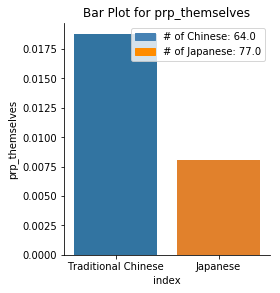

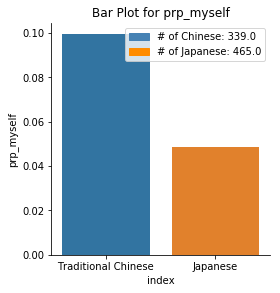

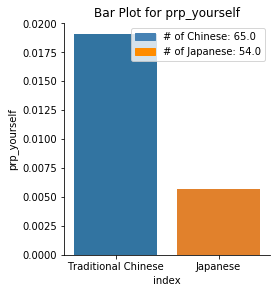

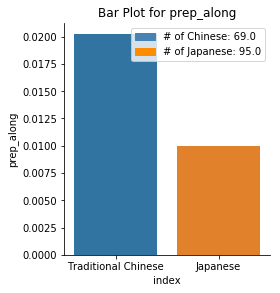

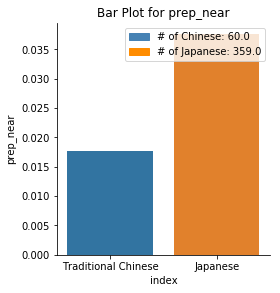

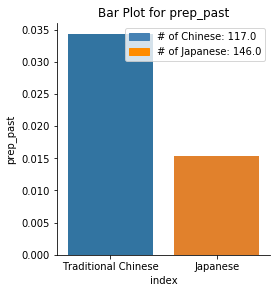

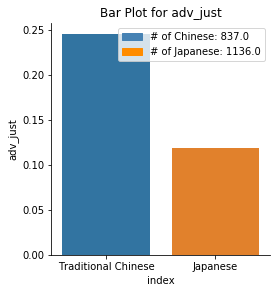

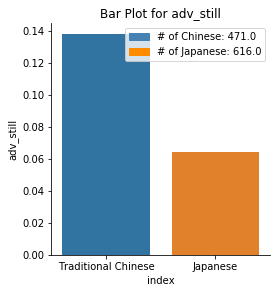

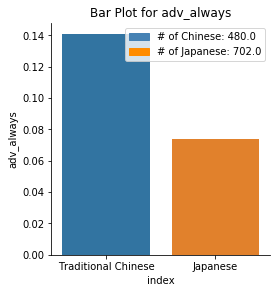

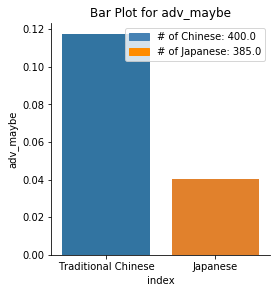

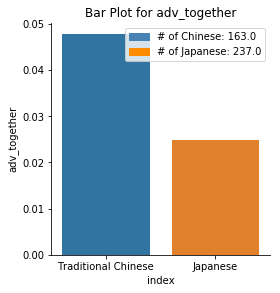

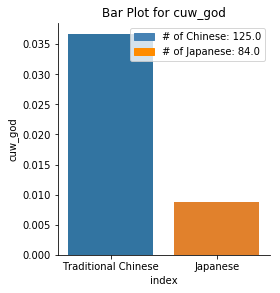

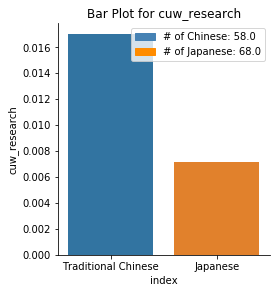

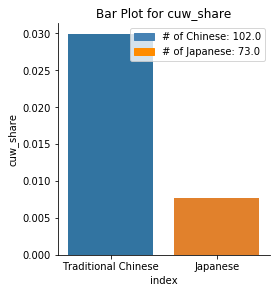

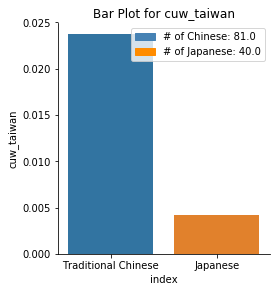

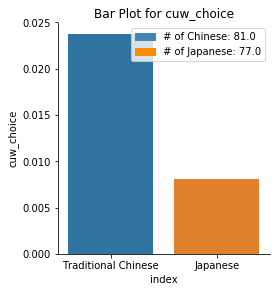

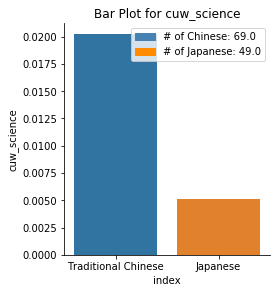

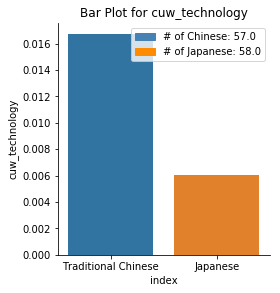

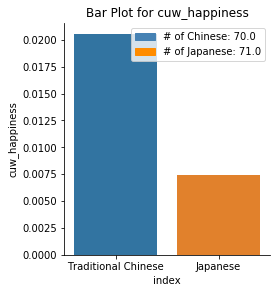

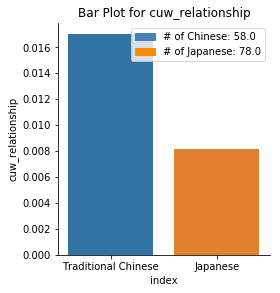

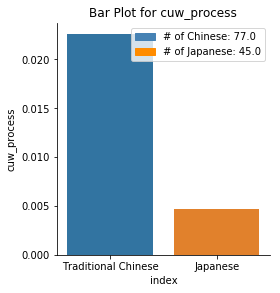

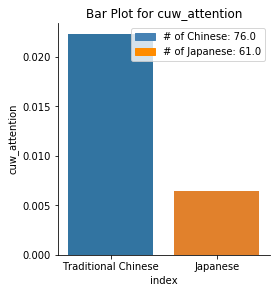

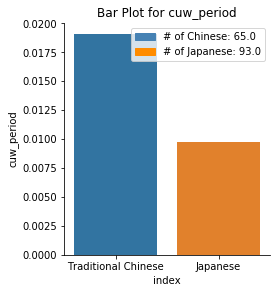

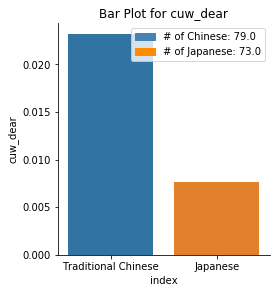

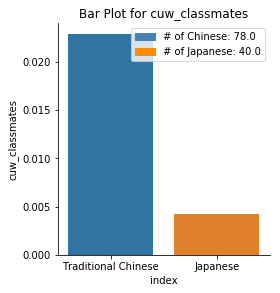

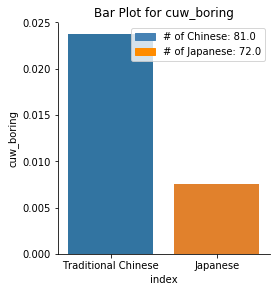

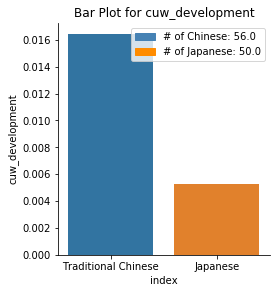

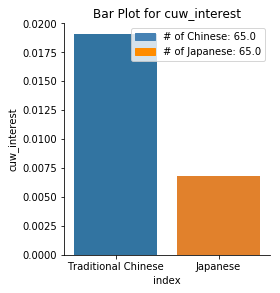

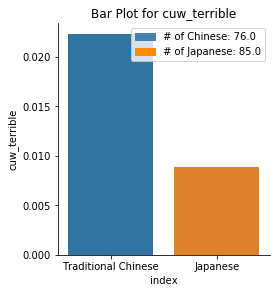

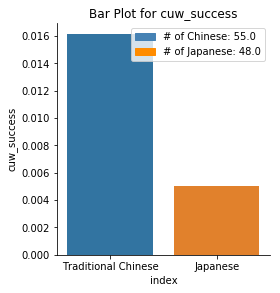

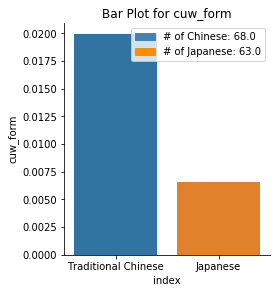

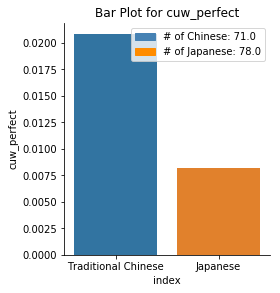

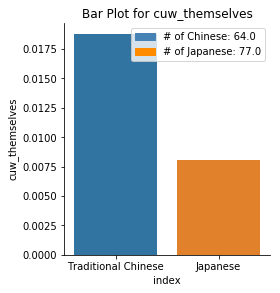

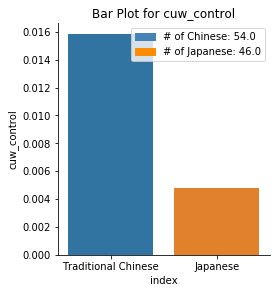

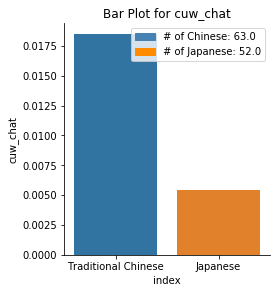

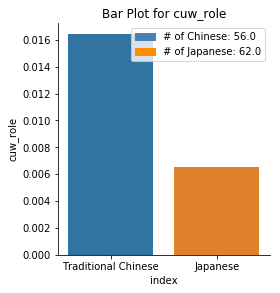

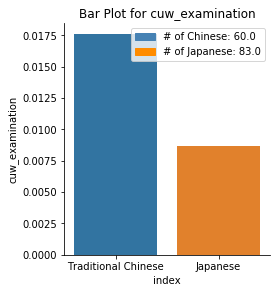

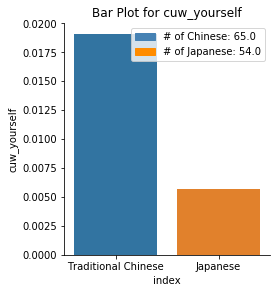

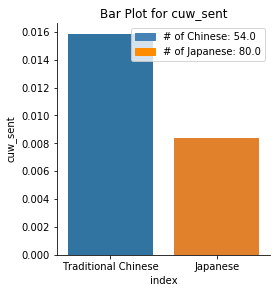

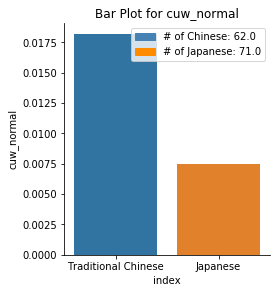

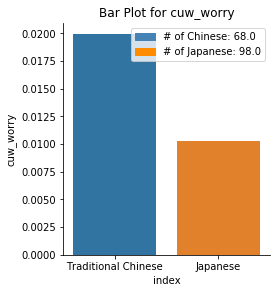

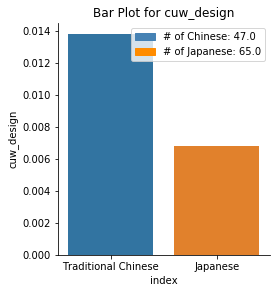

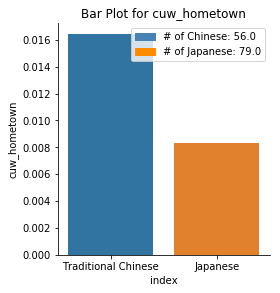

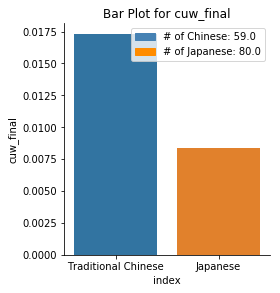

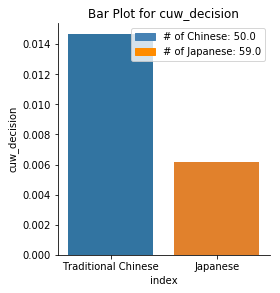

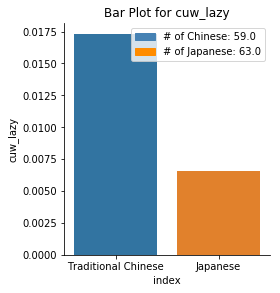

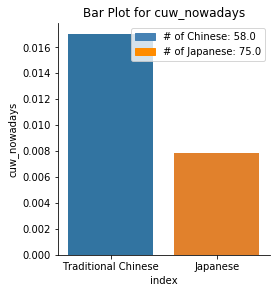

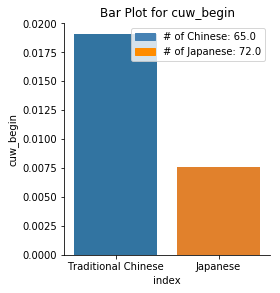

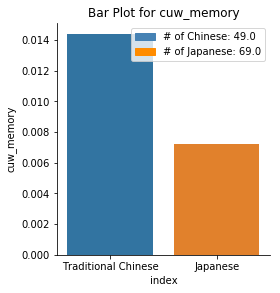

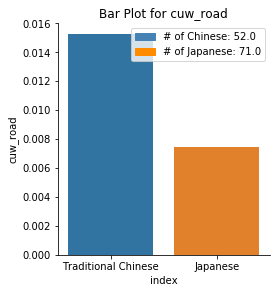

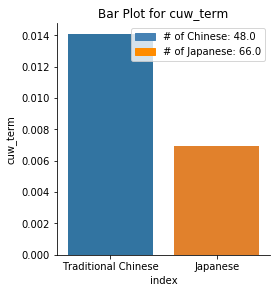

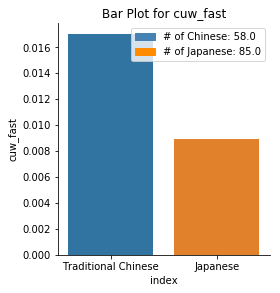

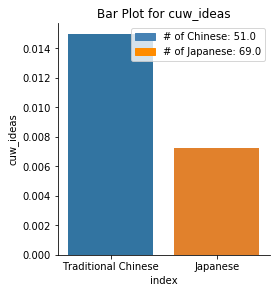

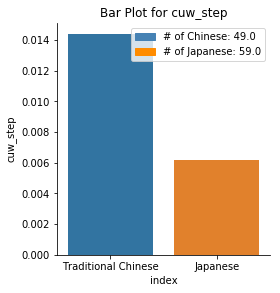

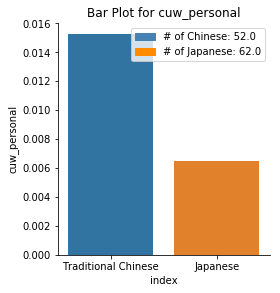

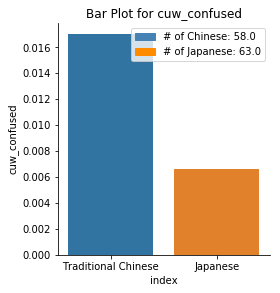

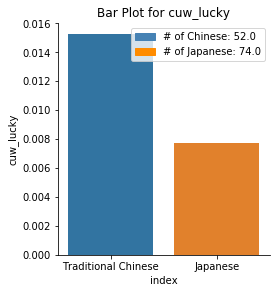

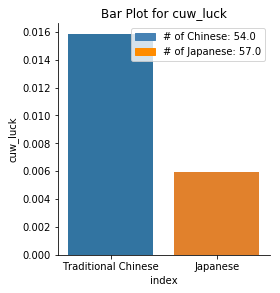

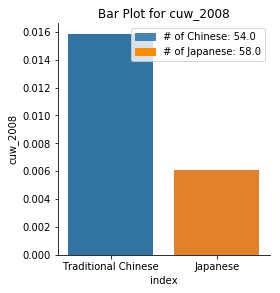

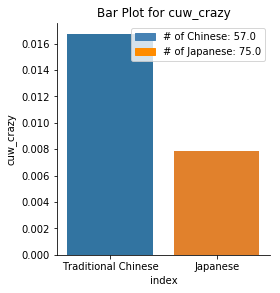

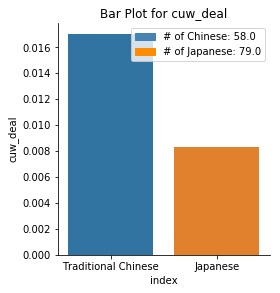

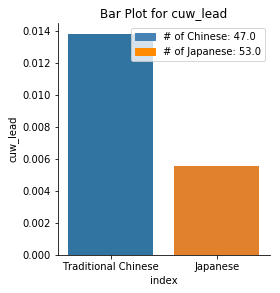

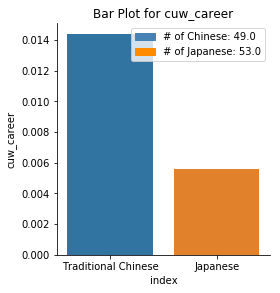

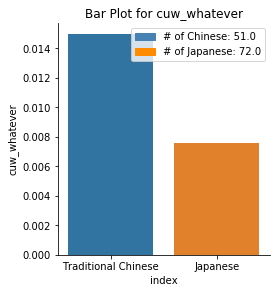

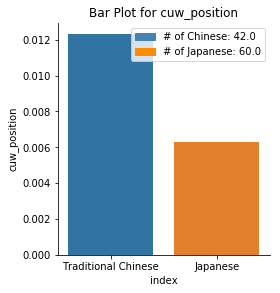

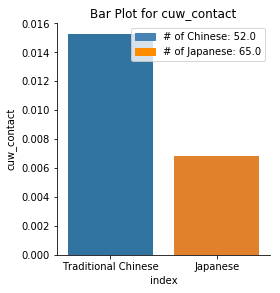

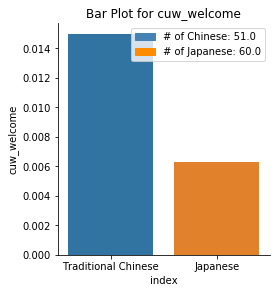

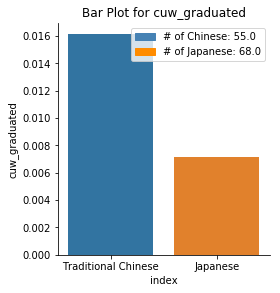

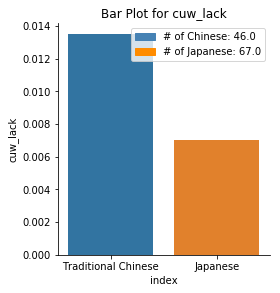

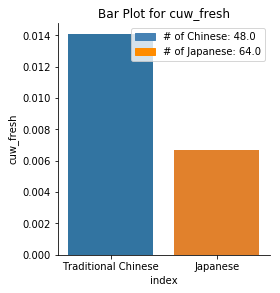

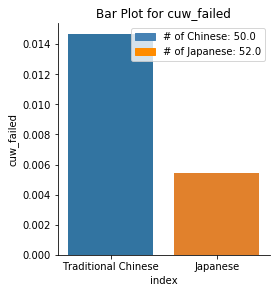

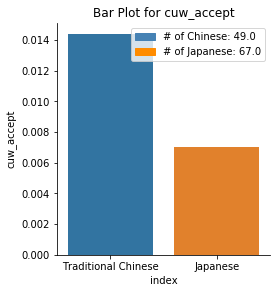

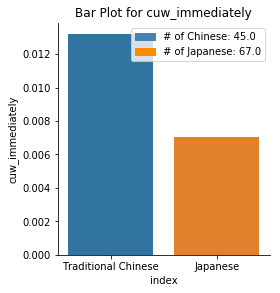

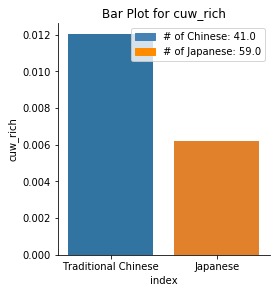

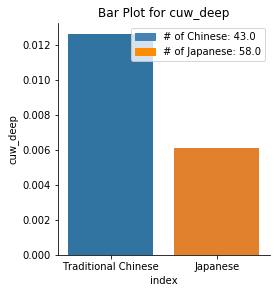

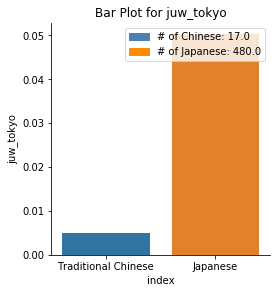

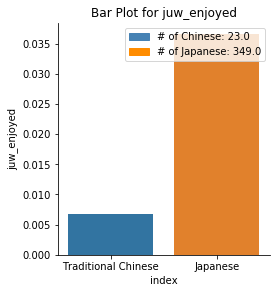

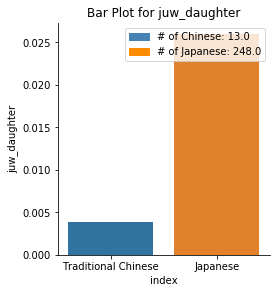

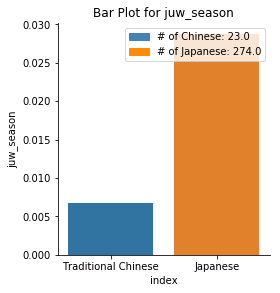

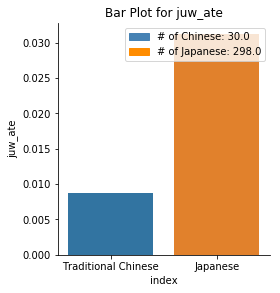

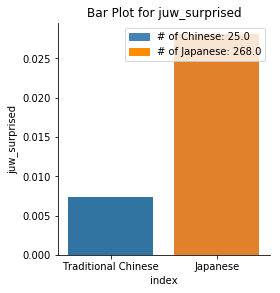

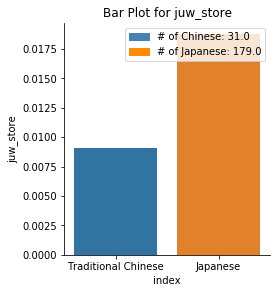

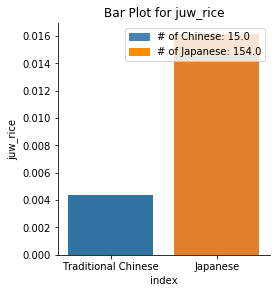

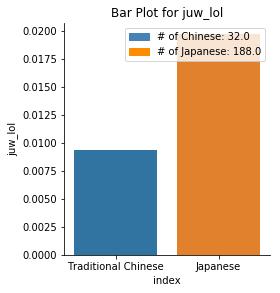

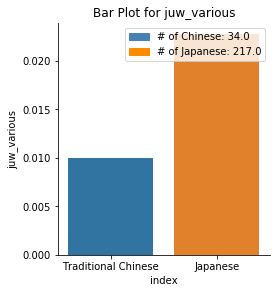

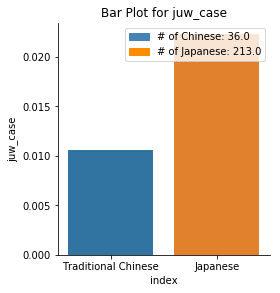

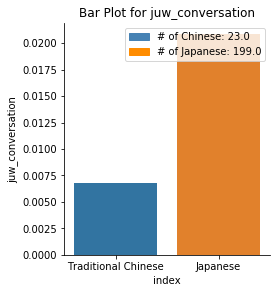

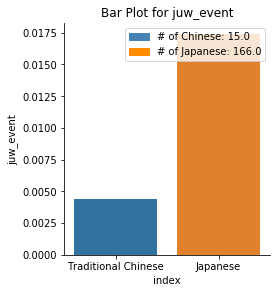

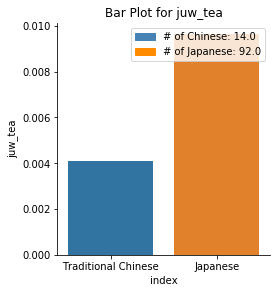

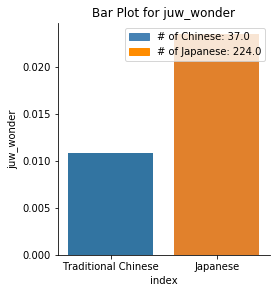

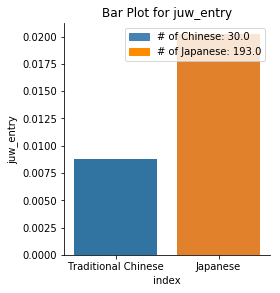

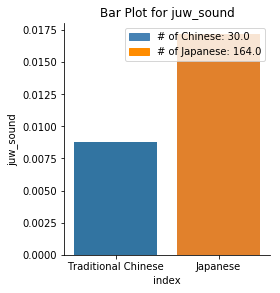

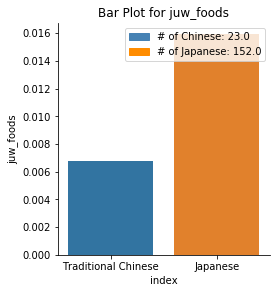

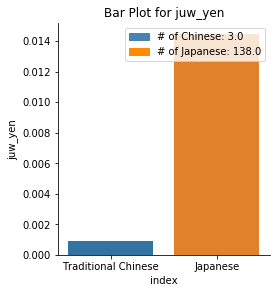

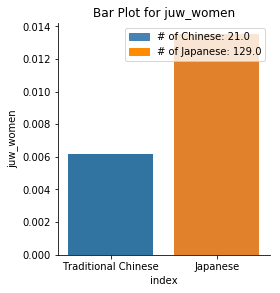

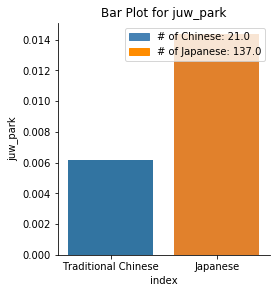

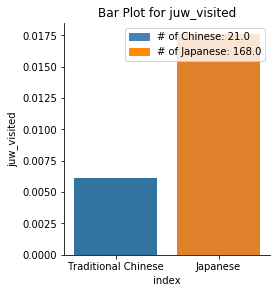

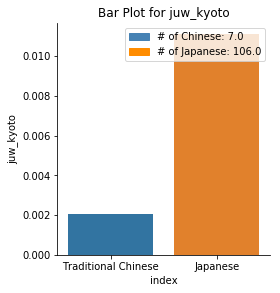

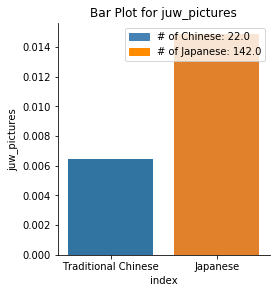

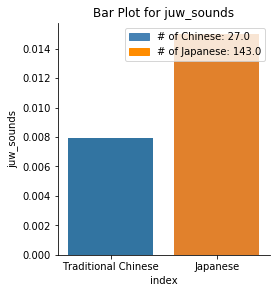

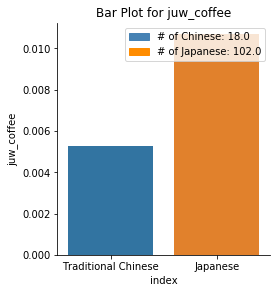

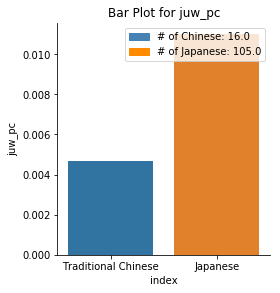

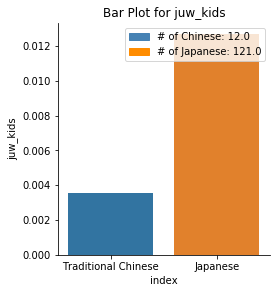

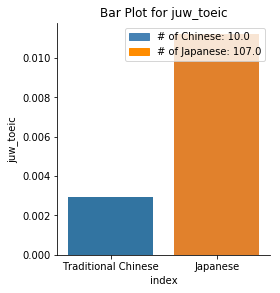

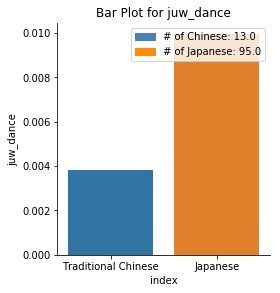

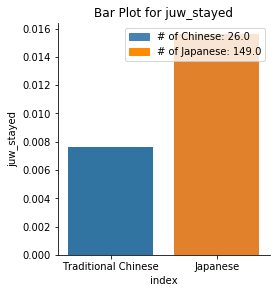

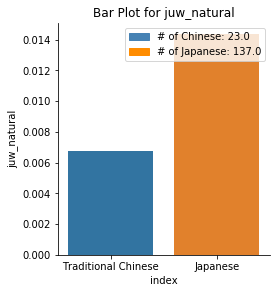

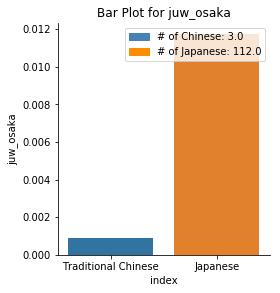

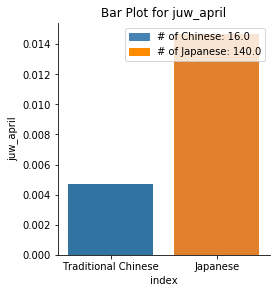

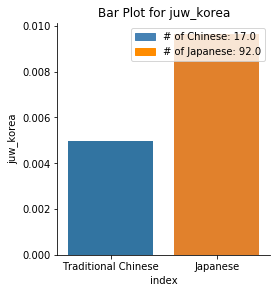

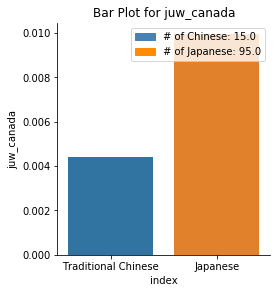

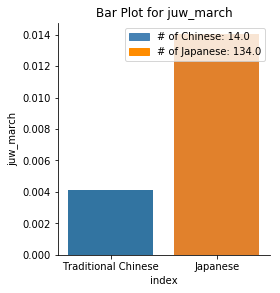

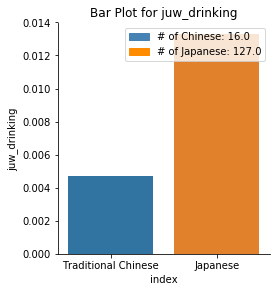

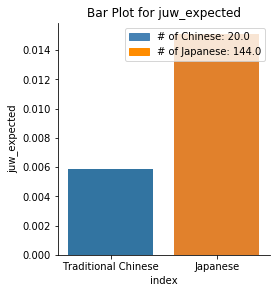

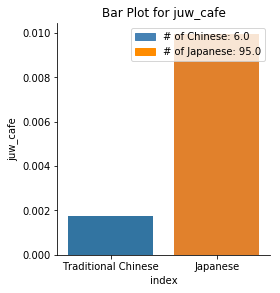

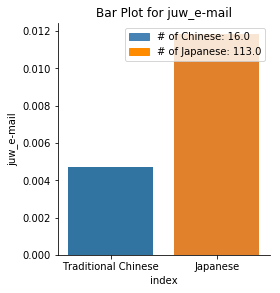

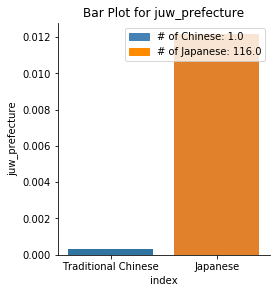

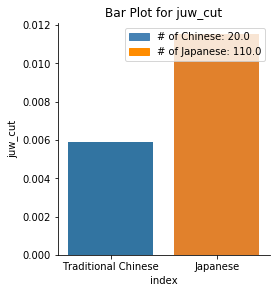

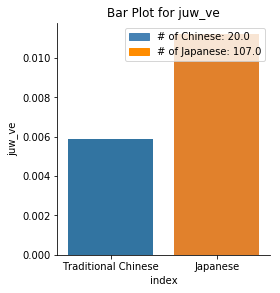

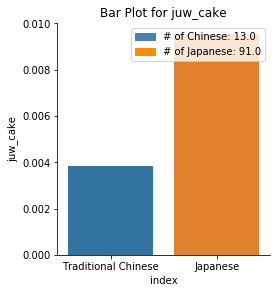

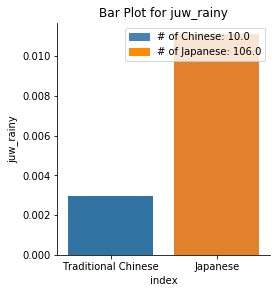

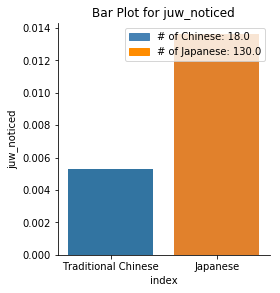

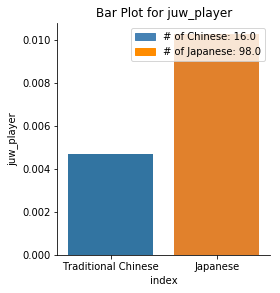

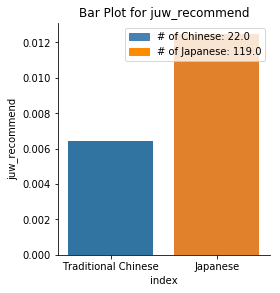

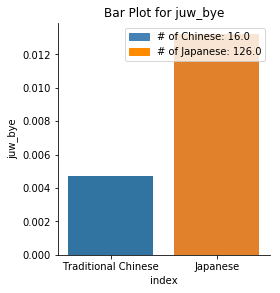

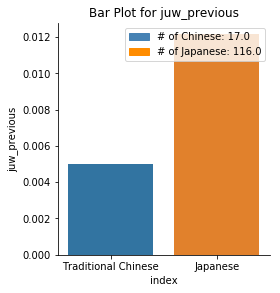

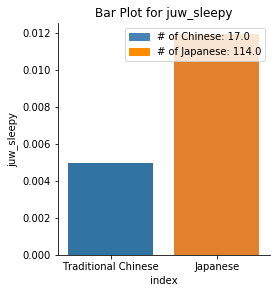

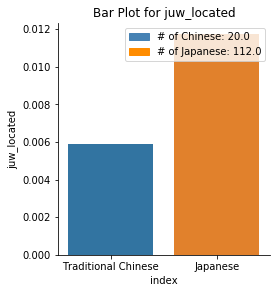

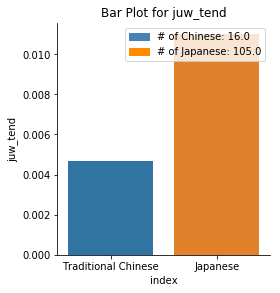

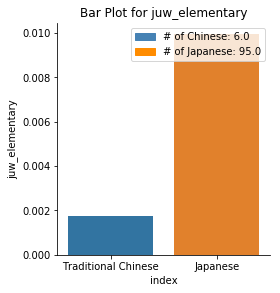

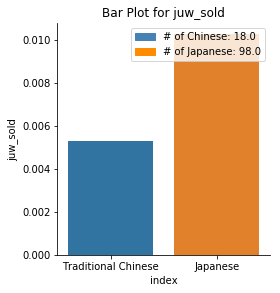

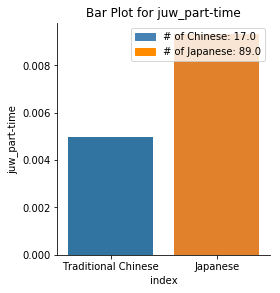

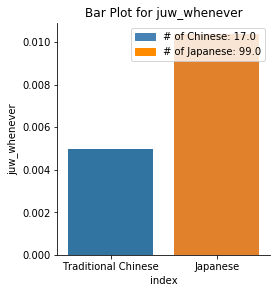

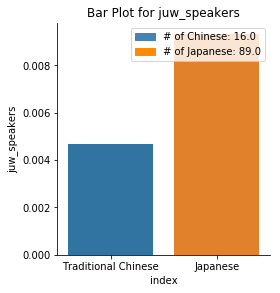

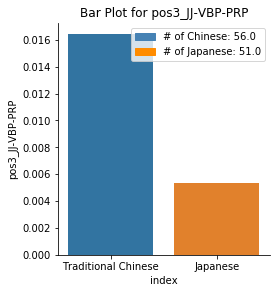

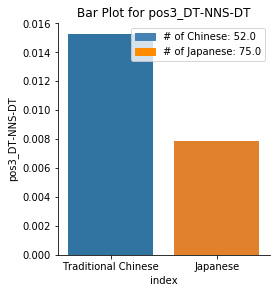

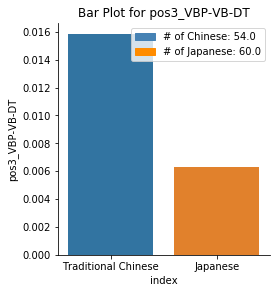

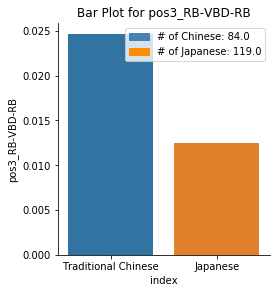

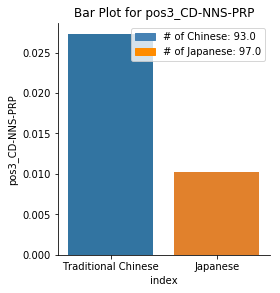

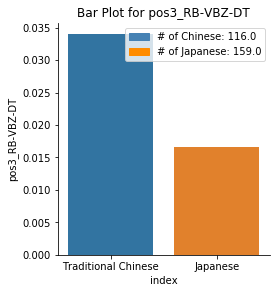

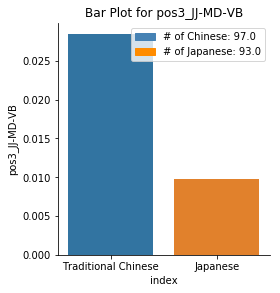

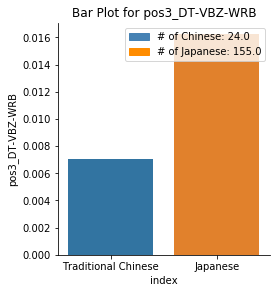

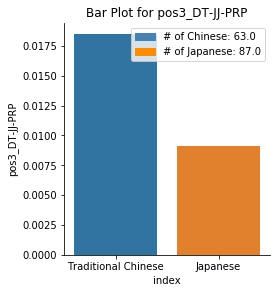

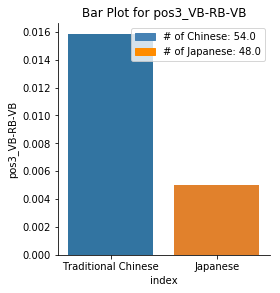

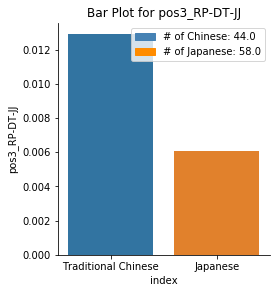

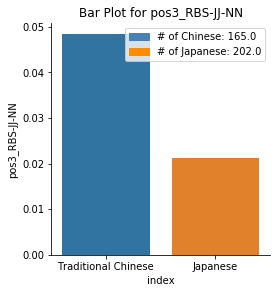

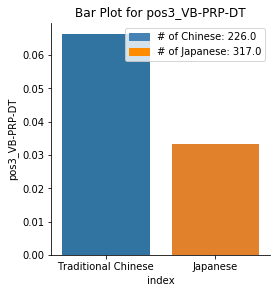

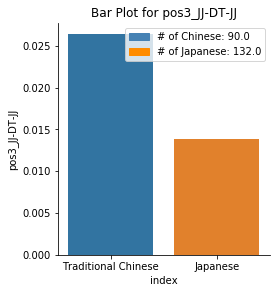

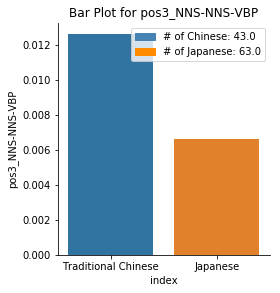

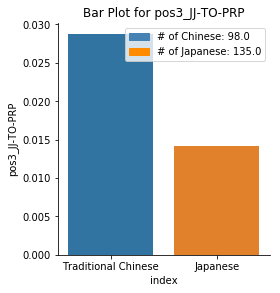

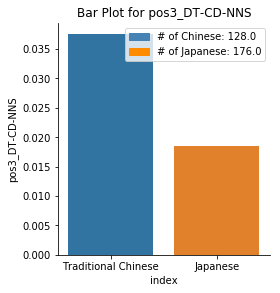

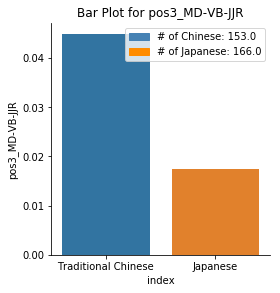

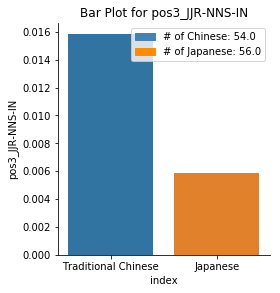

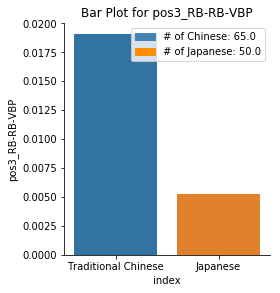

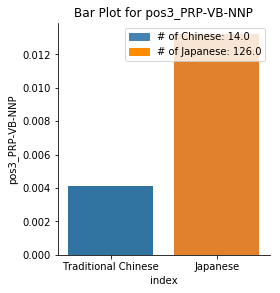

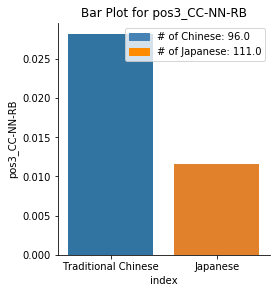

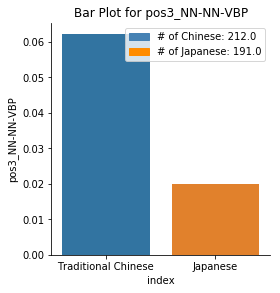

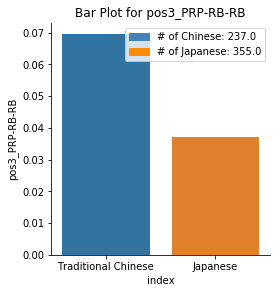

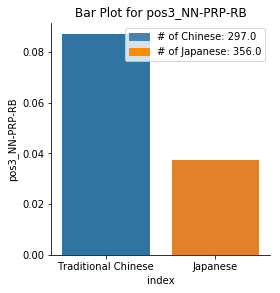

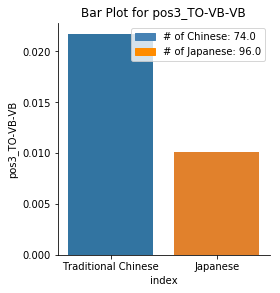

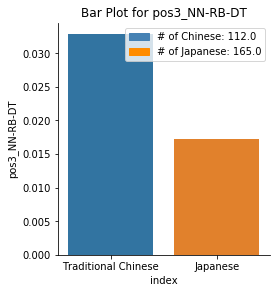

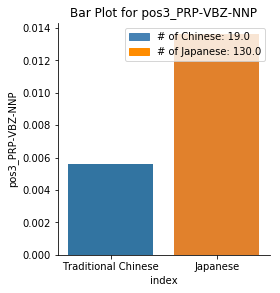

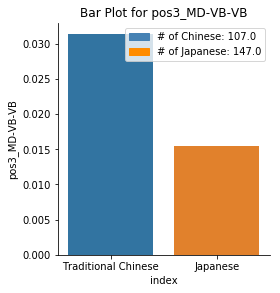

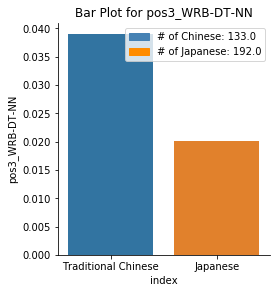

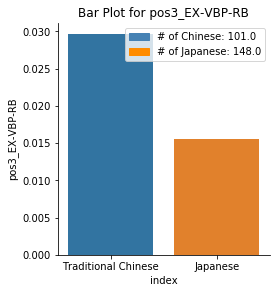

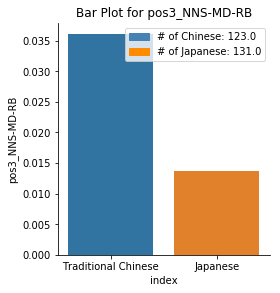

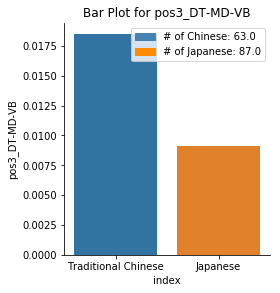

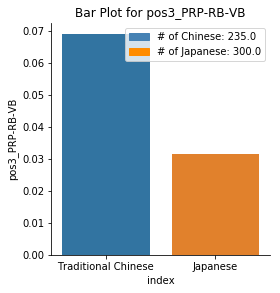

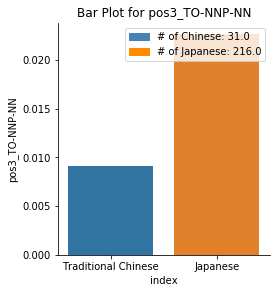

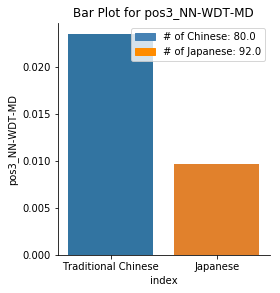

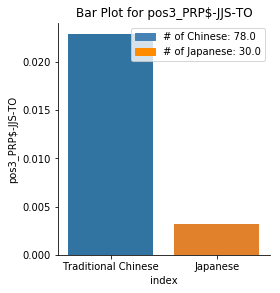

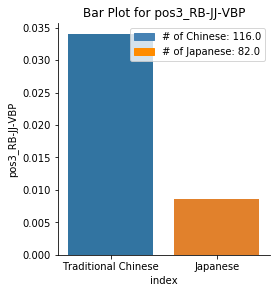

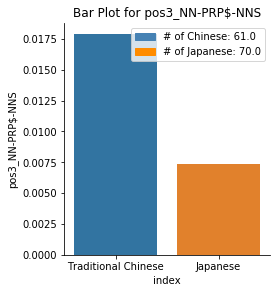

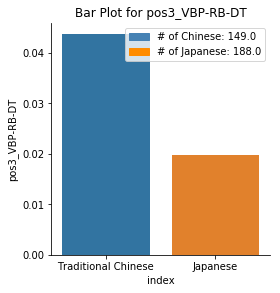

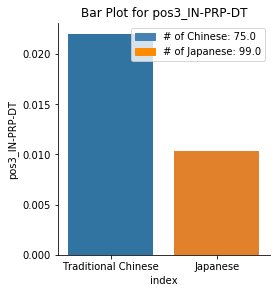

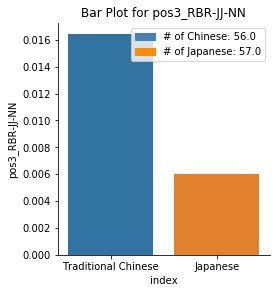

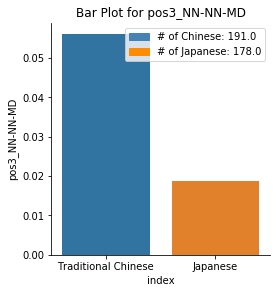

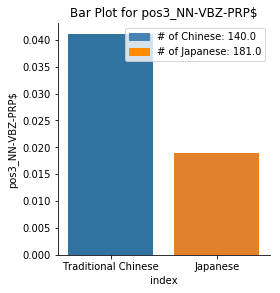

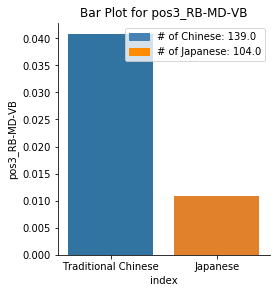

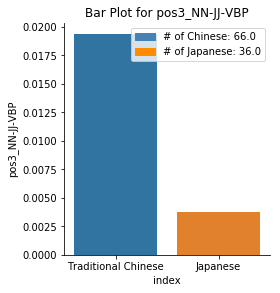

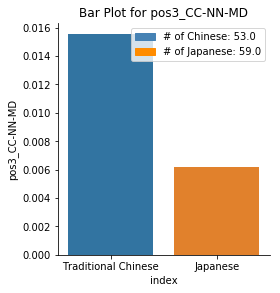

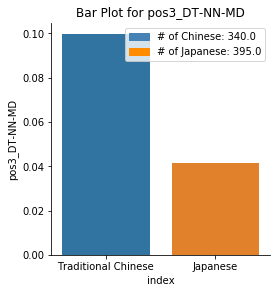

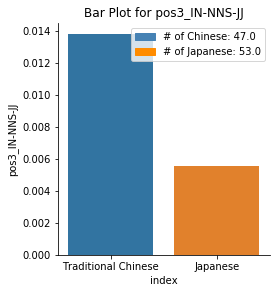

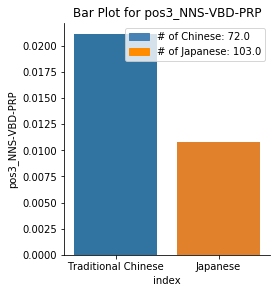

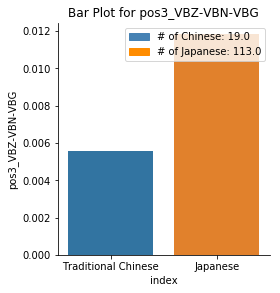

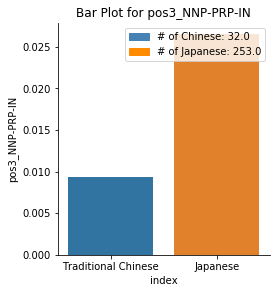

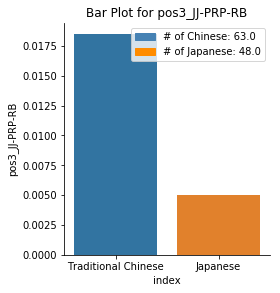

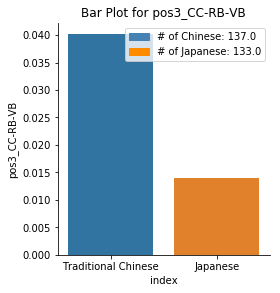

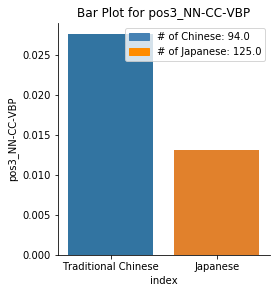

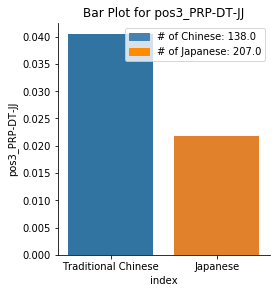

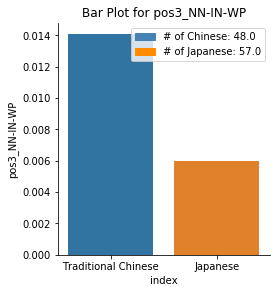

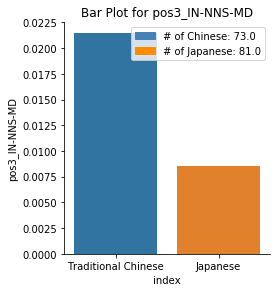

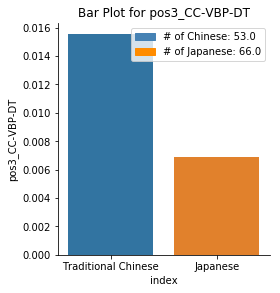

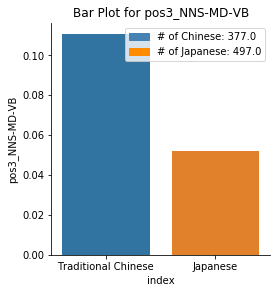

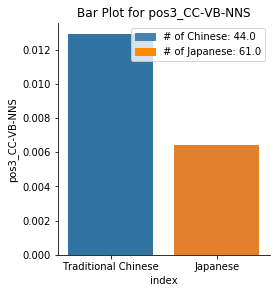

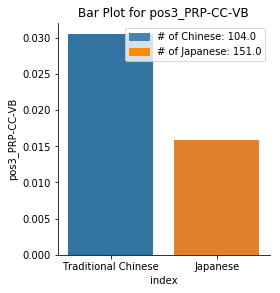

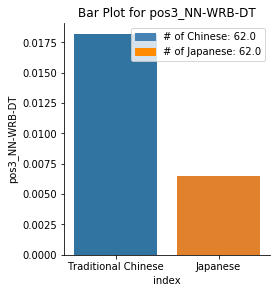

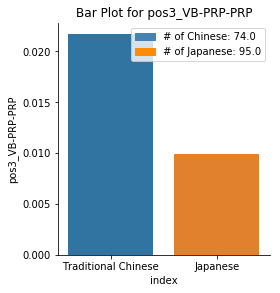

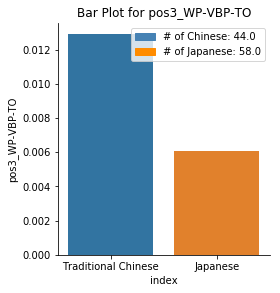

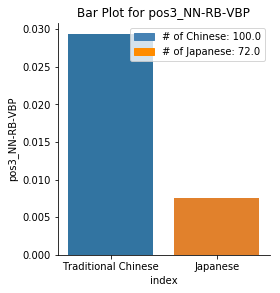

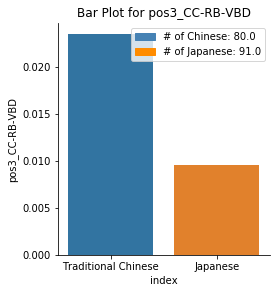

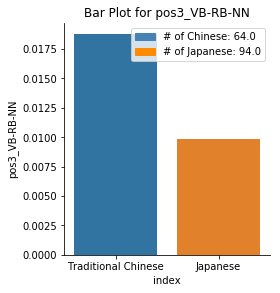

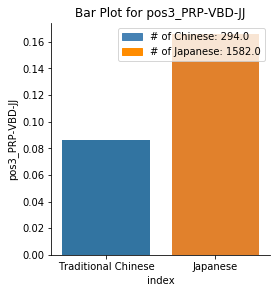

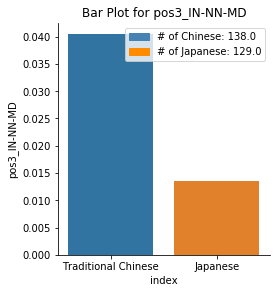

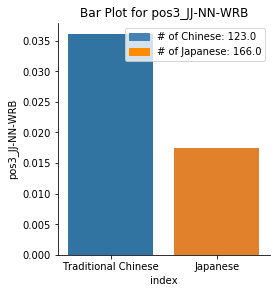

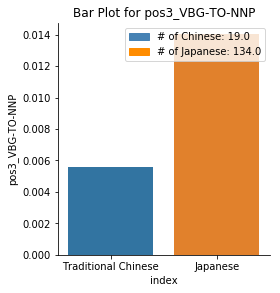

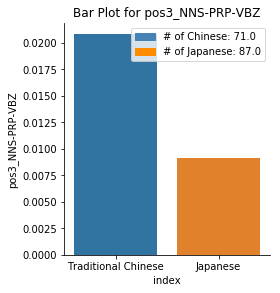

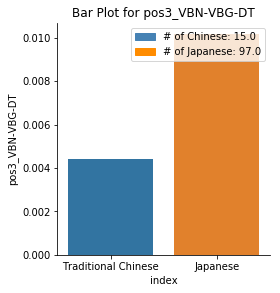

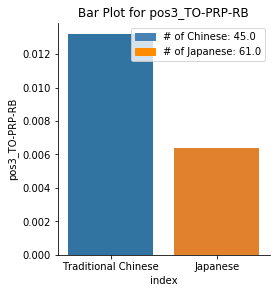

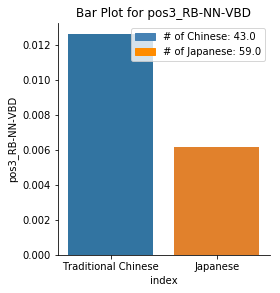

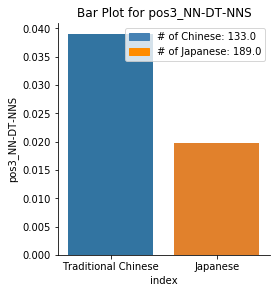

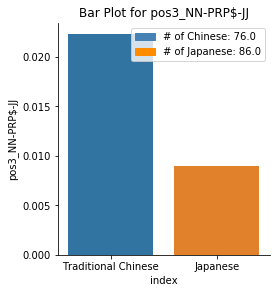

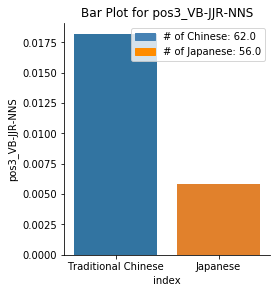

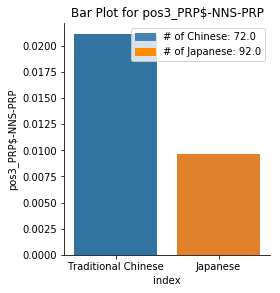

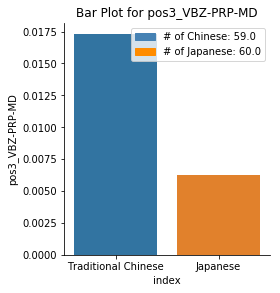

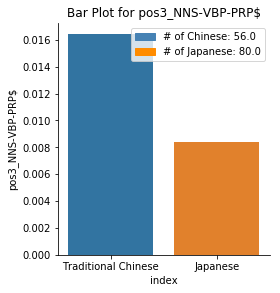

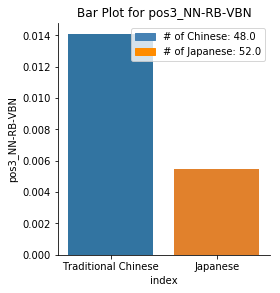

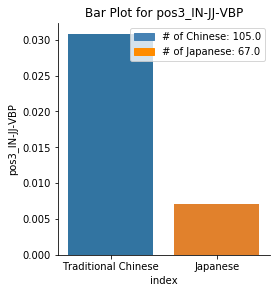

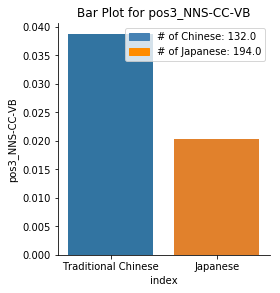

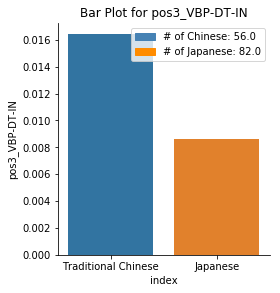

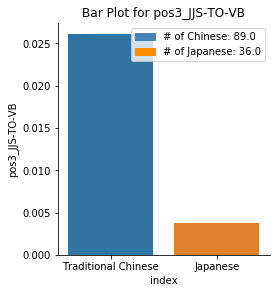

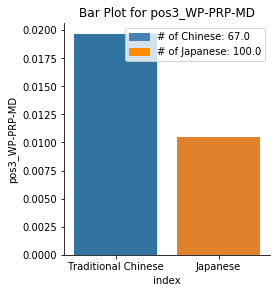

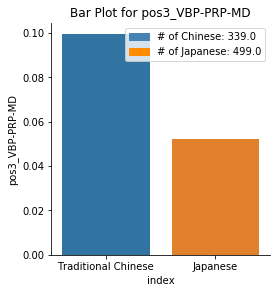

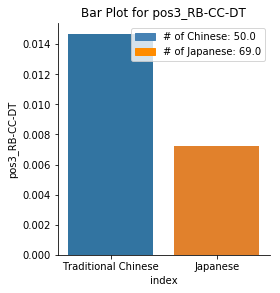

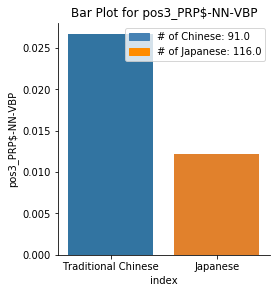

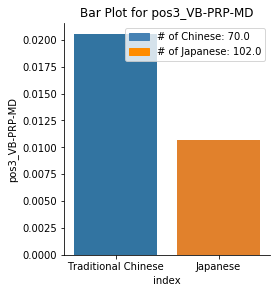

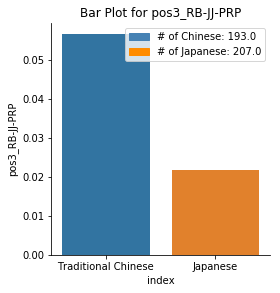

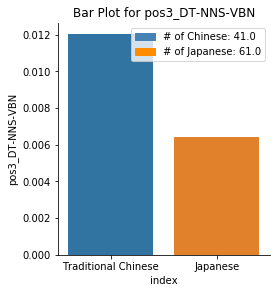

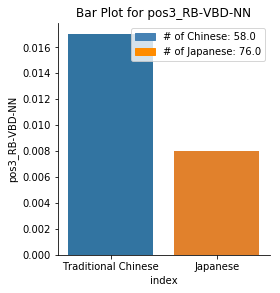

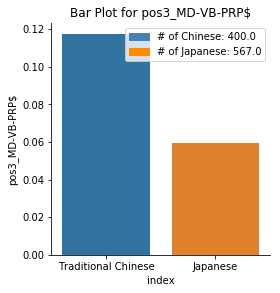

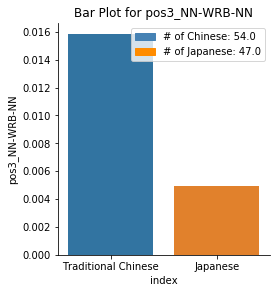

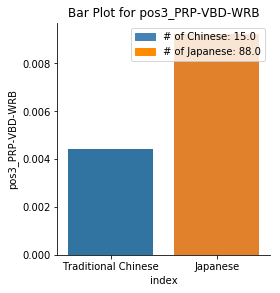

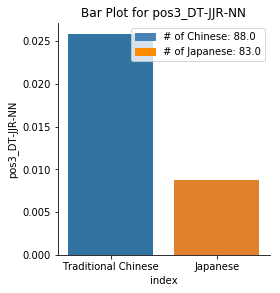

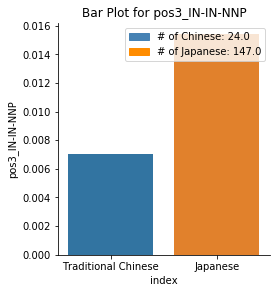

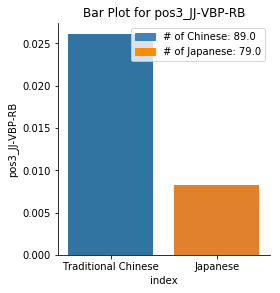

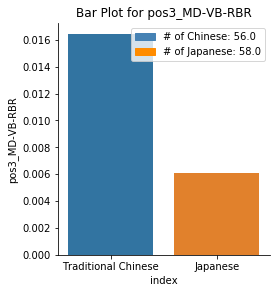

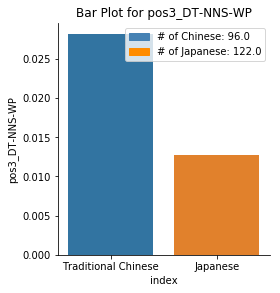

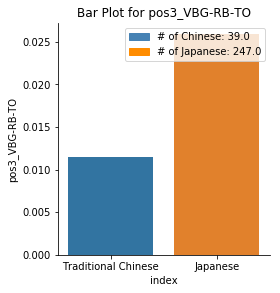

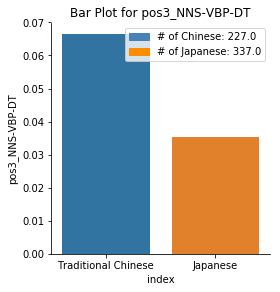

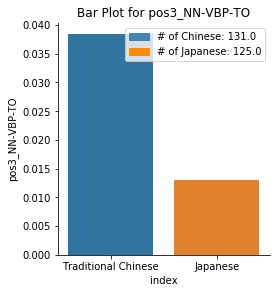

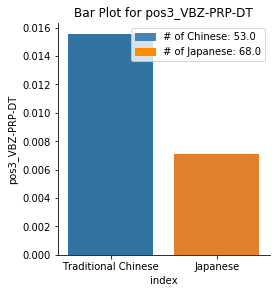

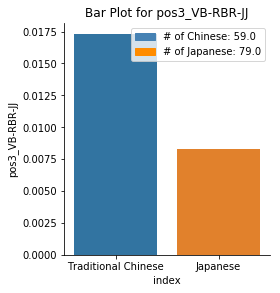

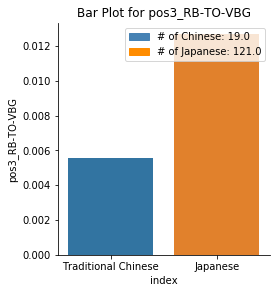

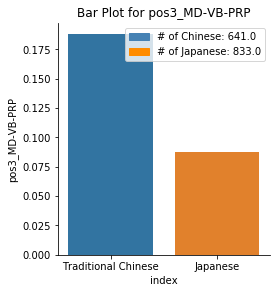

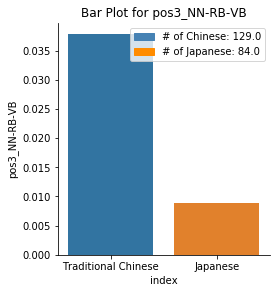

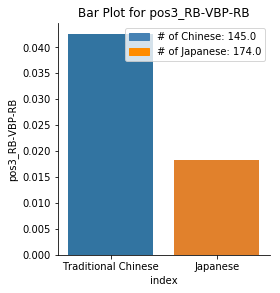

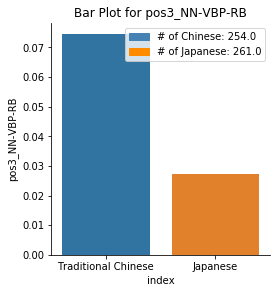

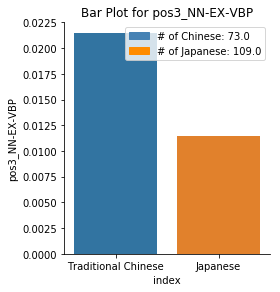

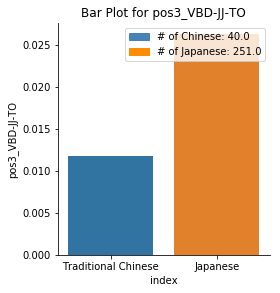

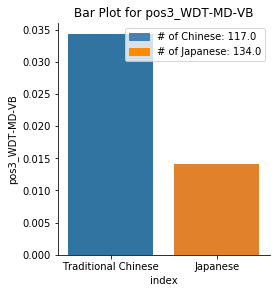

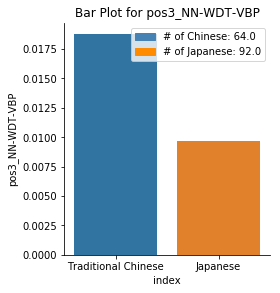

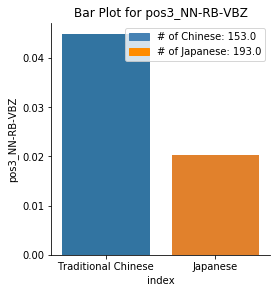

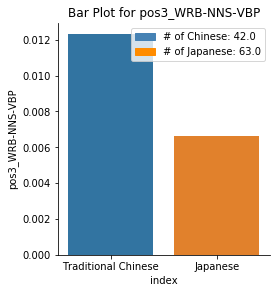

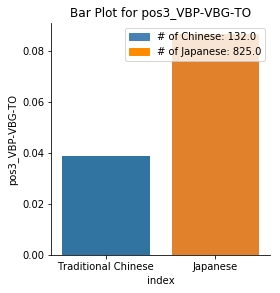

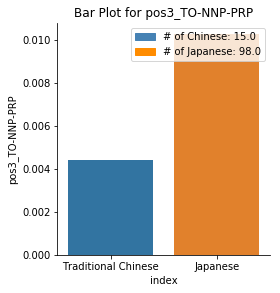

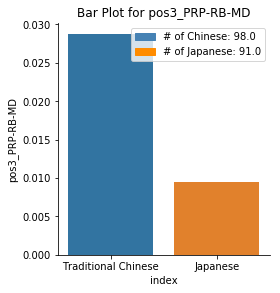

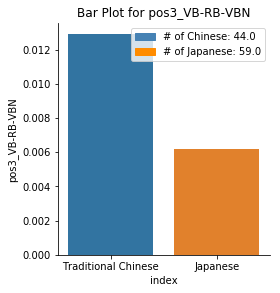

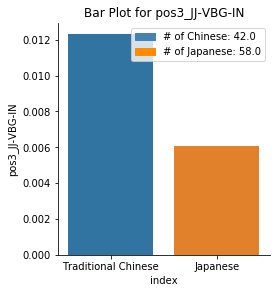

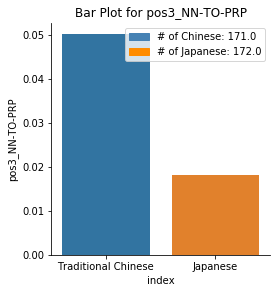

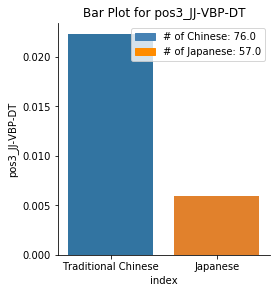

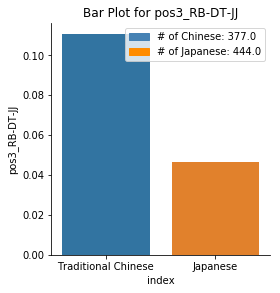

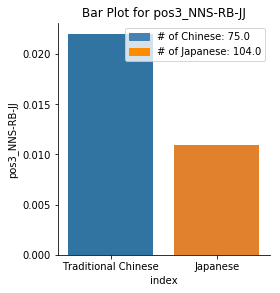

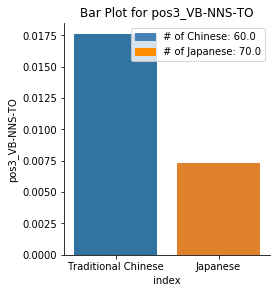

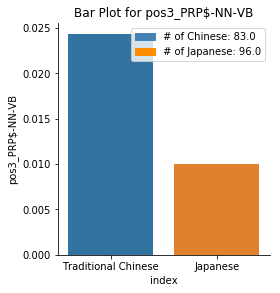

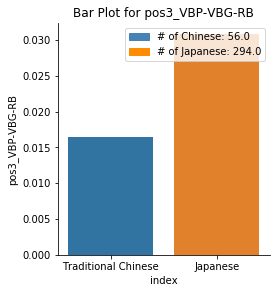

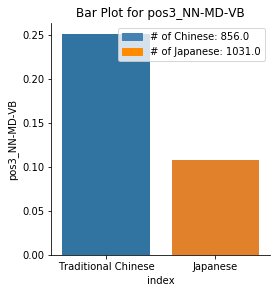

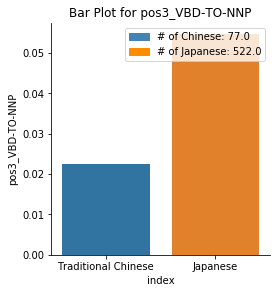

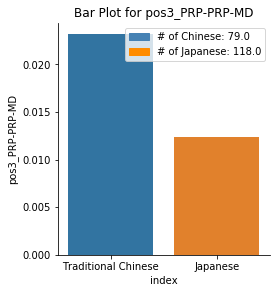

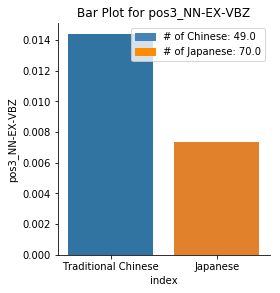

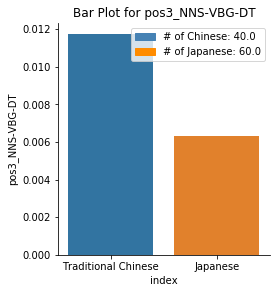

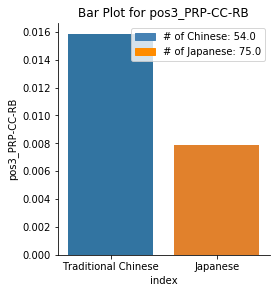

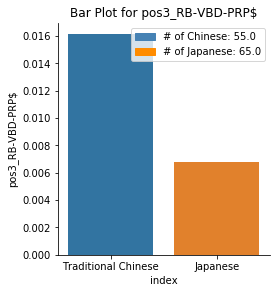

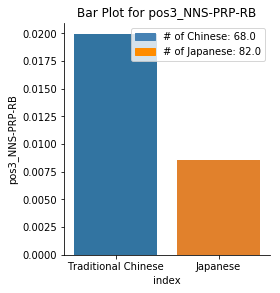

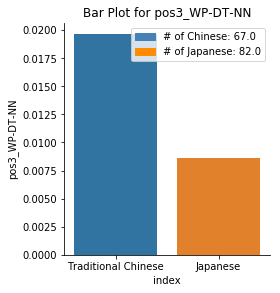

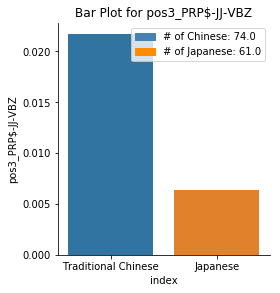

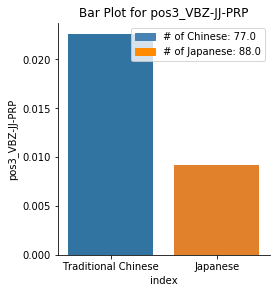

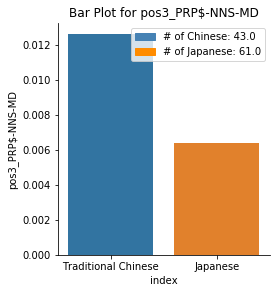

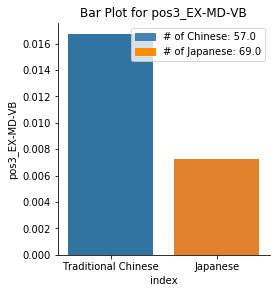

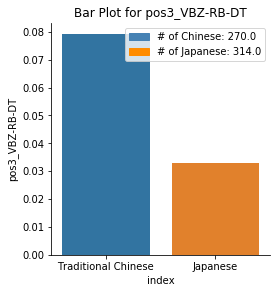

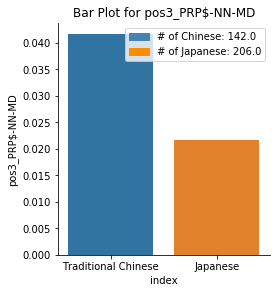

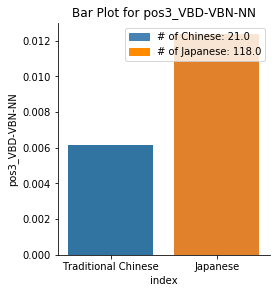

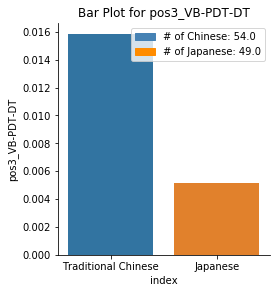

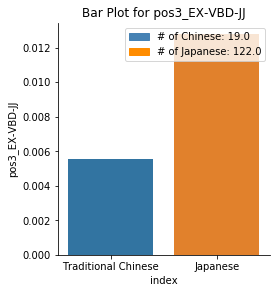

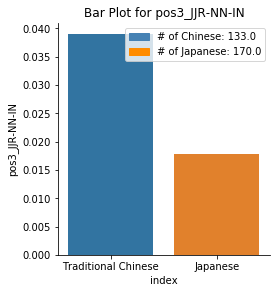

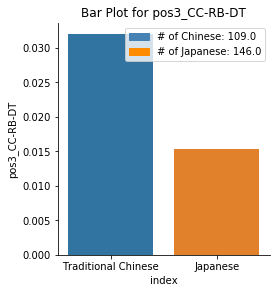

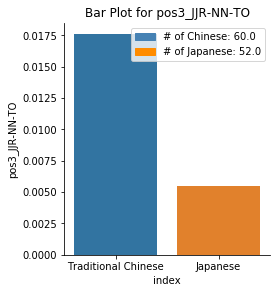

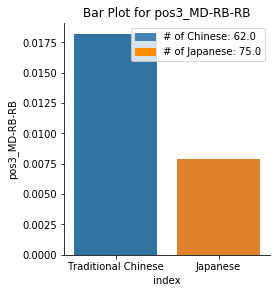

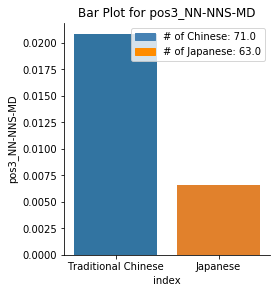

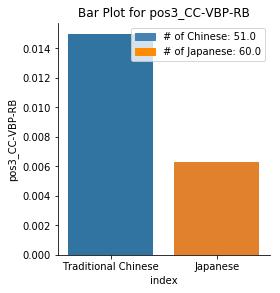

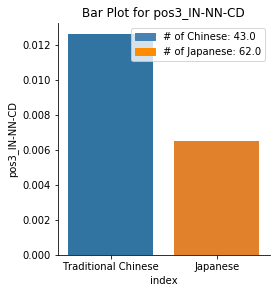

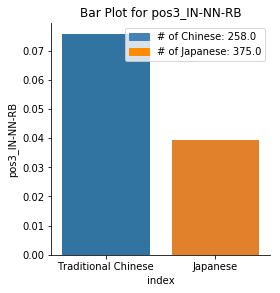

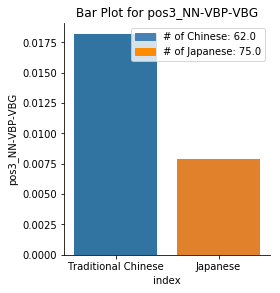

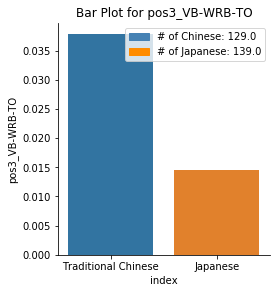

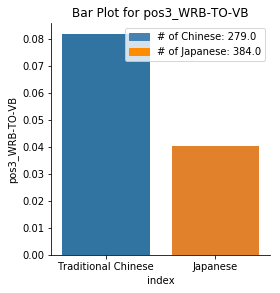

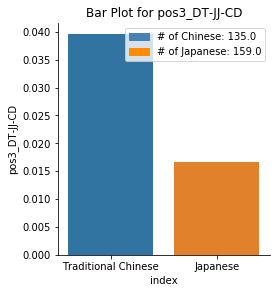

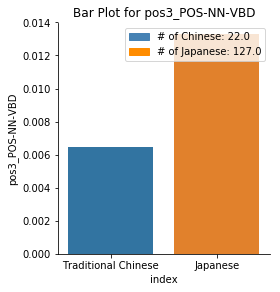

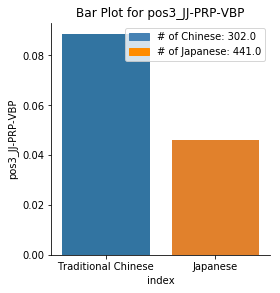

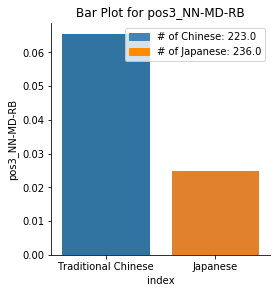

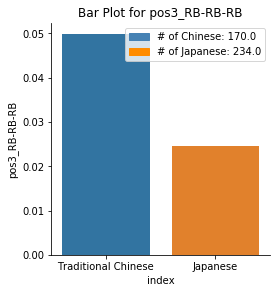

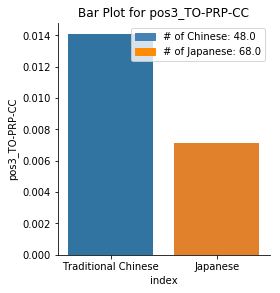

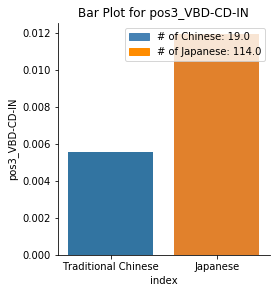

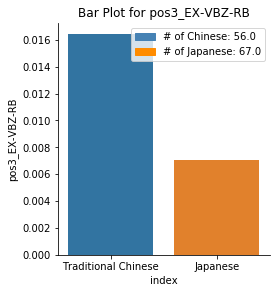

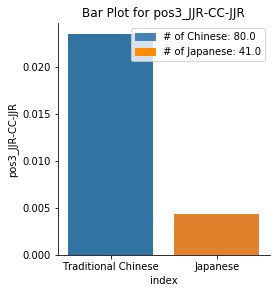

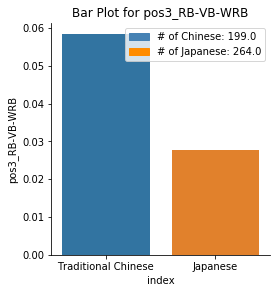

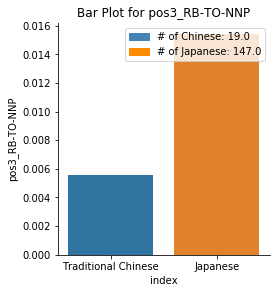

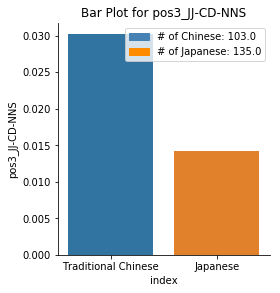

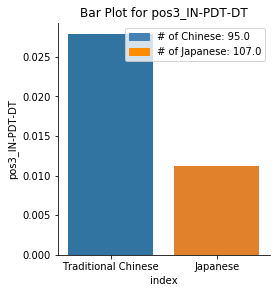

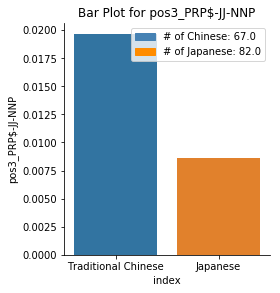

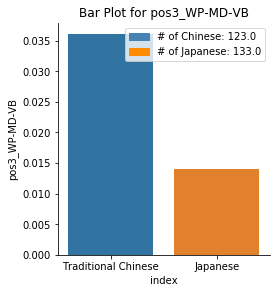

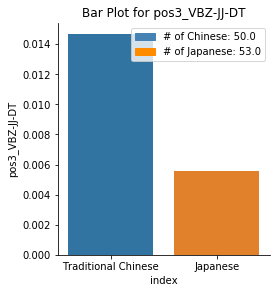

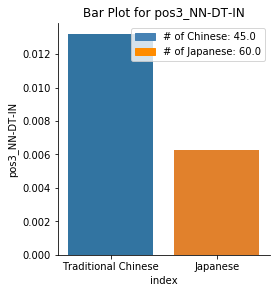

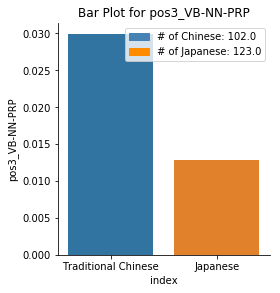

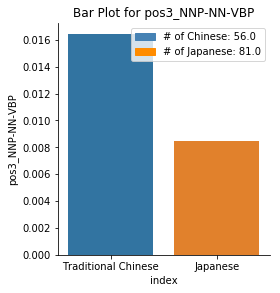

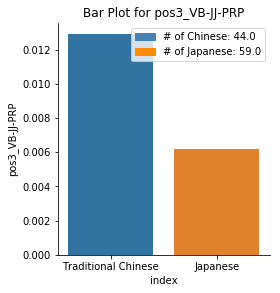

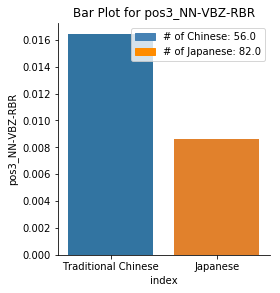

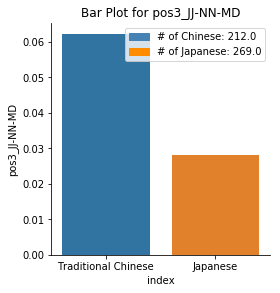

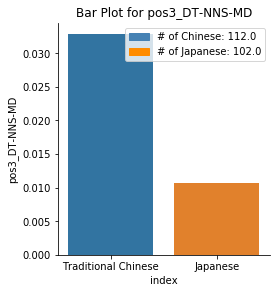

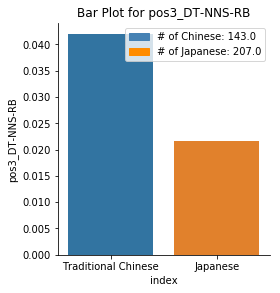

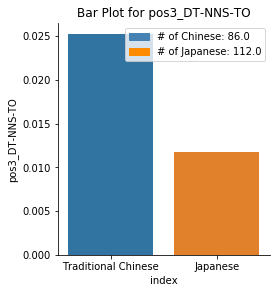

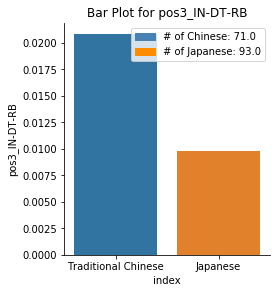

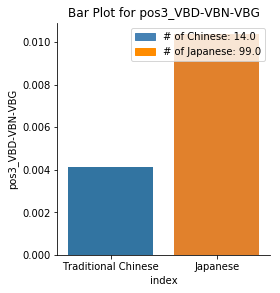

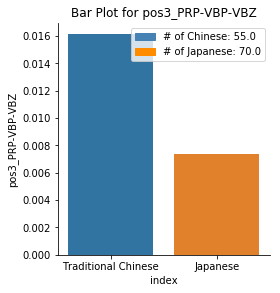

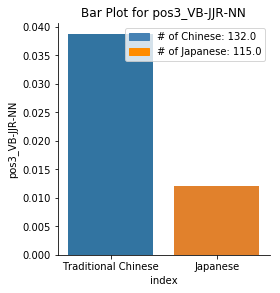

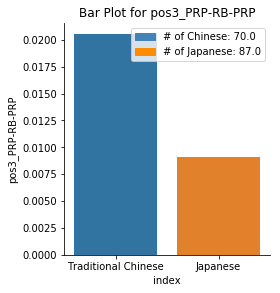

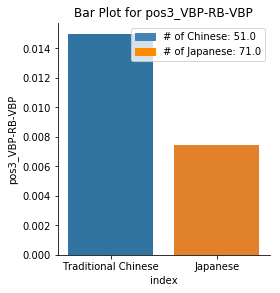

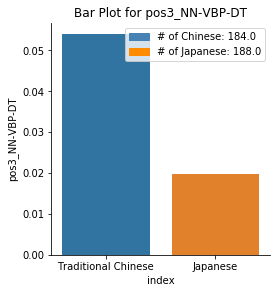

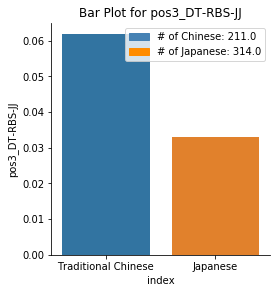

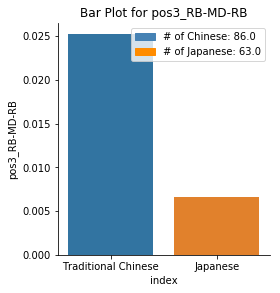

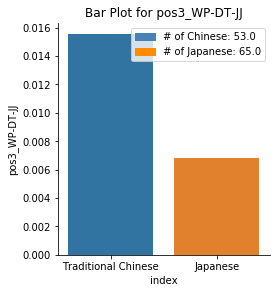

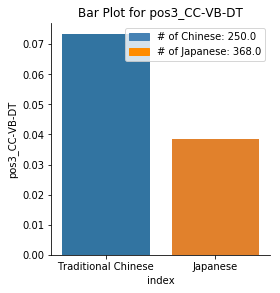

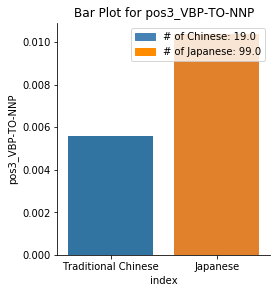

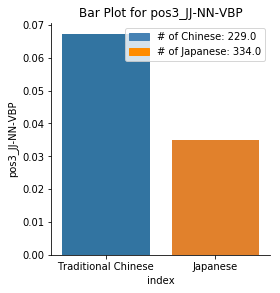

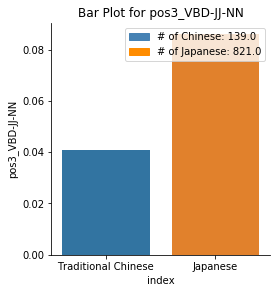

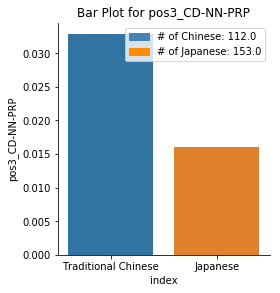

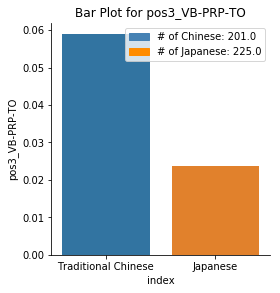

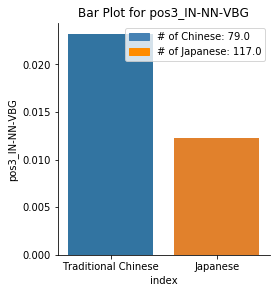

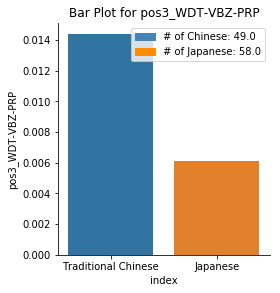

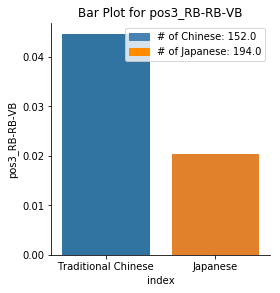

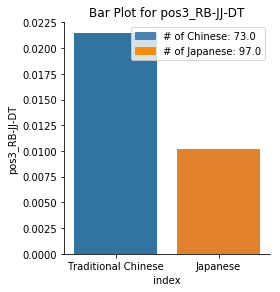

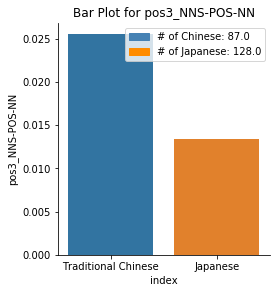

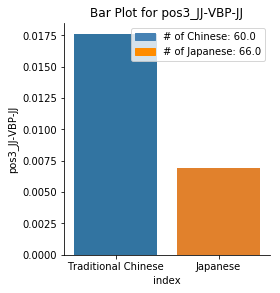

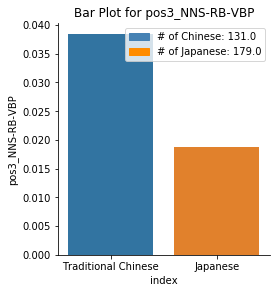

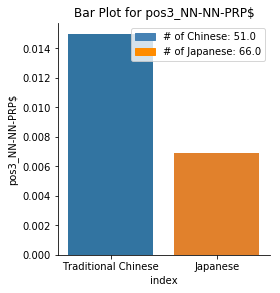

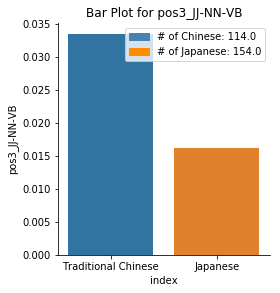

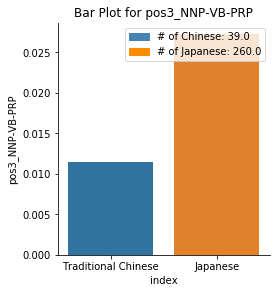

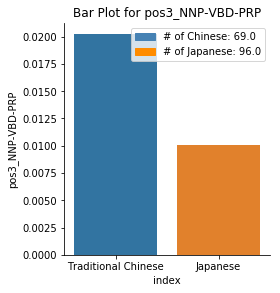

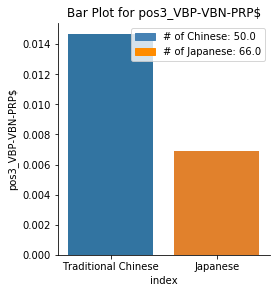

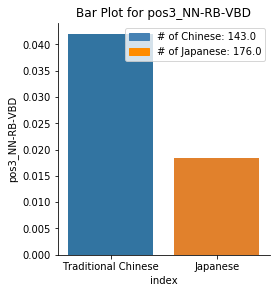

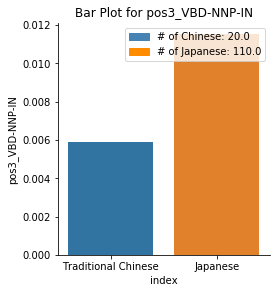

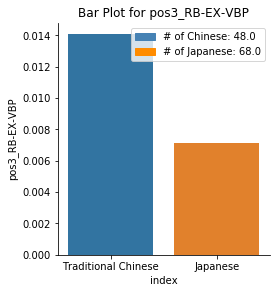

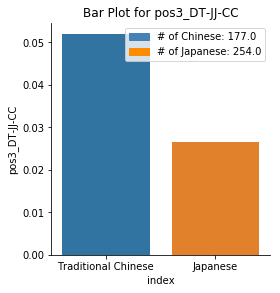

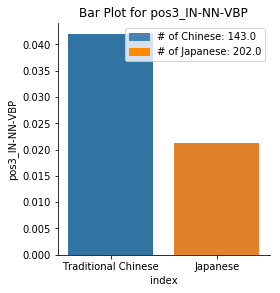

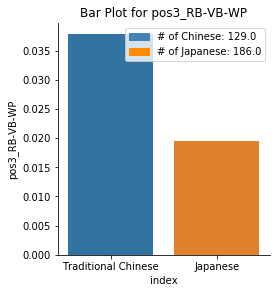

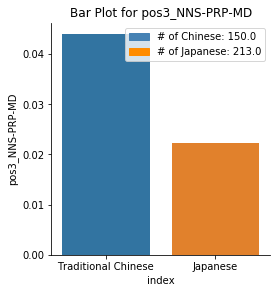

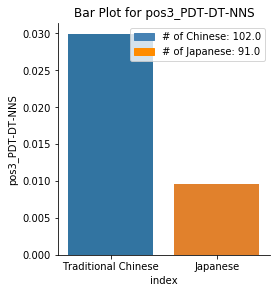

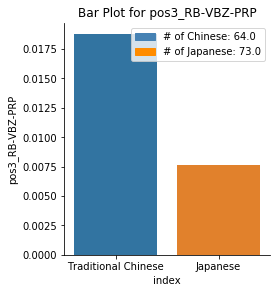

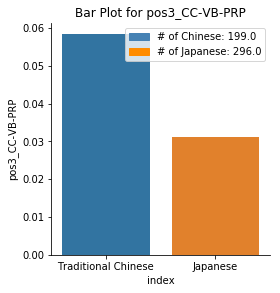

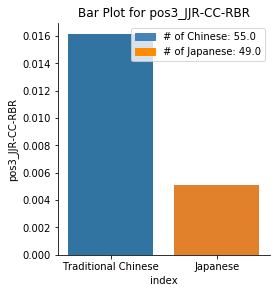

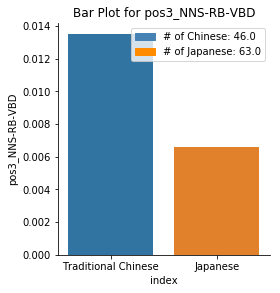

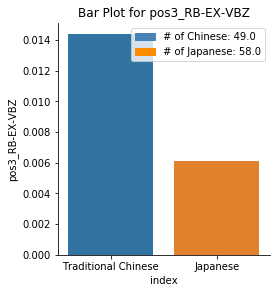

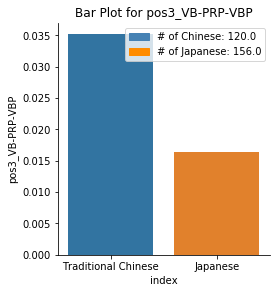

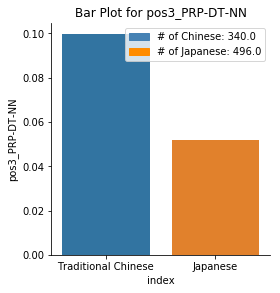

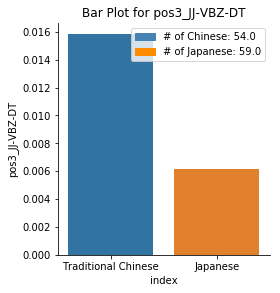

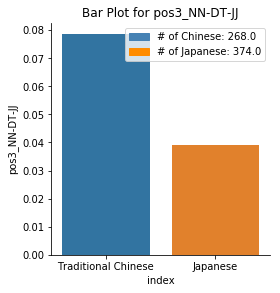

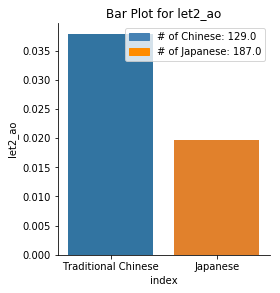

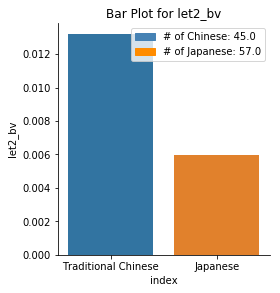

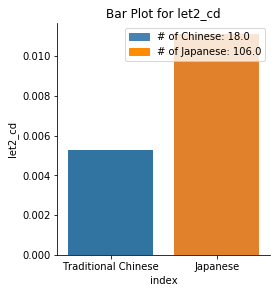

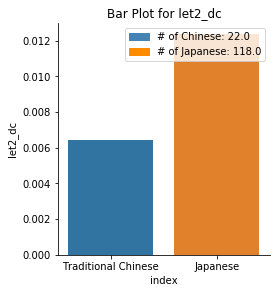

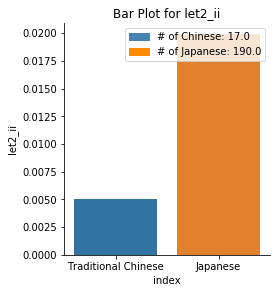

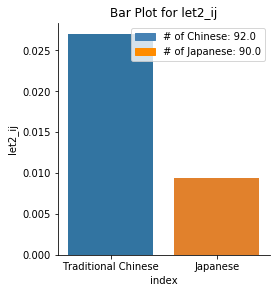

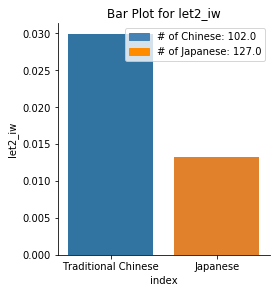

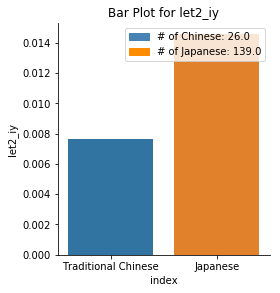

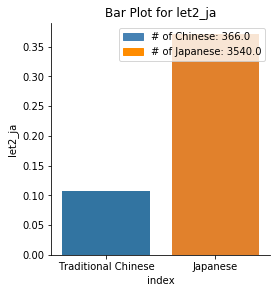

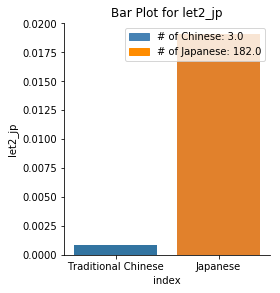

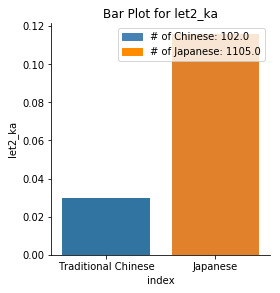

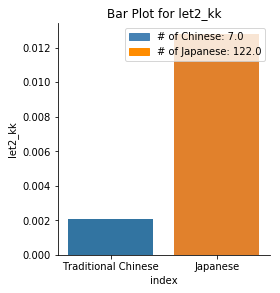

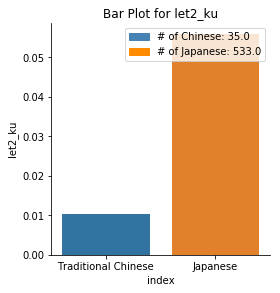

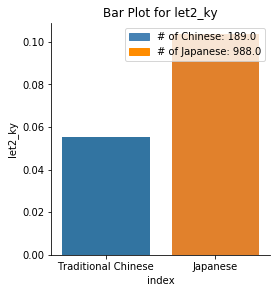

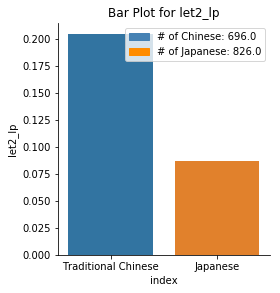

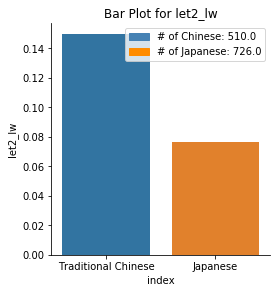

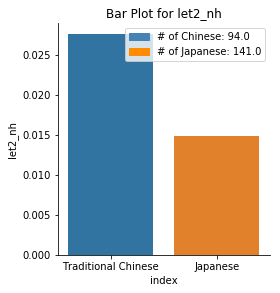

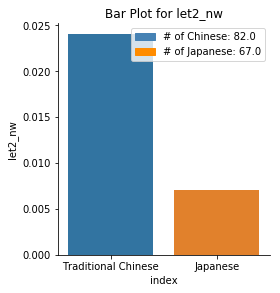

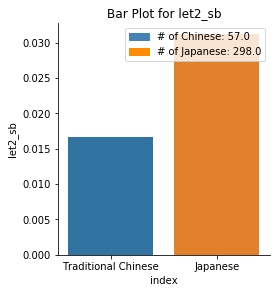

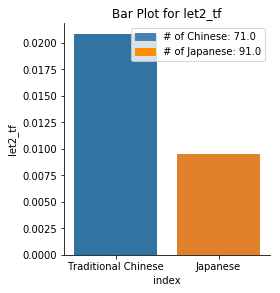

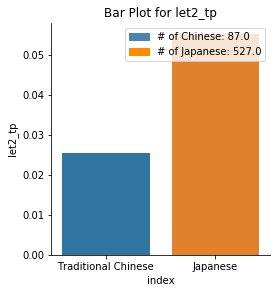

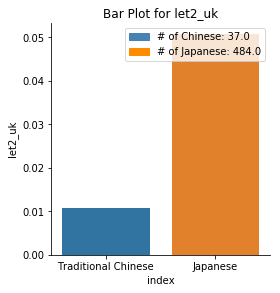

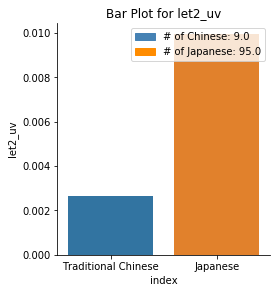

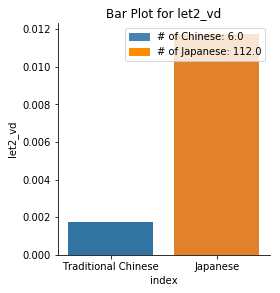

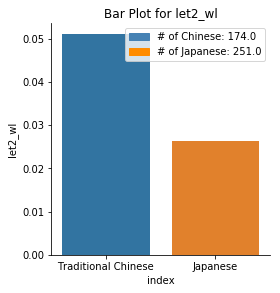

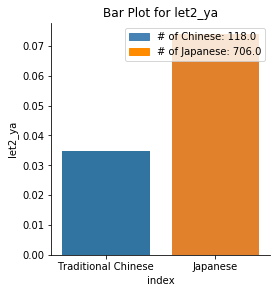

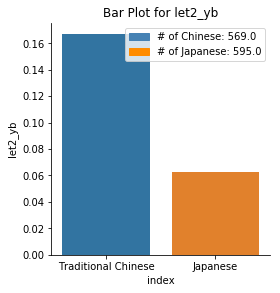

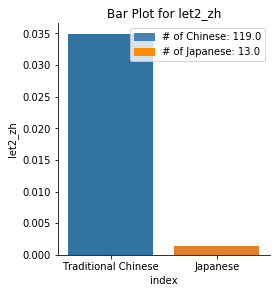

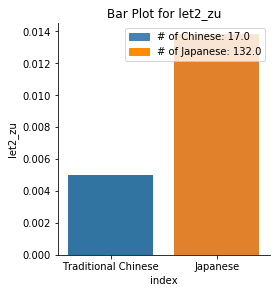

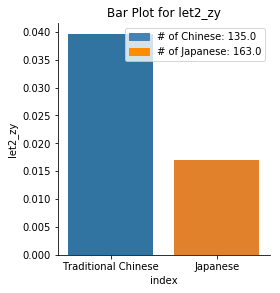

Stored 'keepfeatures' (list)


In [128]:
from scipy.stats import binom_test

# keepfeatures = []
for feat in list(languagesDF.columns):
    if feat != 'language':
        
        if (check_differences(languagesDF[feat]) > .6) and languagesDF[feat].sum()>100:
            graph_vis(feat,True)
#             keepfeatures.append(feat)       
plt.show()
%store keepfeatures

__Reject Outliers__

In [54]:
def MEDIAN_reject_outliers(data, m=3):
    data = data[abs(data - np.median(data)) < m*robust.mad(data)]
    return data[~np.isnan(data)].sort_values()


def MEAN_reject_outliers(data, m=3):
    data = data[abs(data - np.mean(data)) < m*np.std(data)]
    return data[~np.isnan(data)].sort_values()

__Create Analysis DF__

In [46]:
analysis_features=['letters_per','wc','sc','sent_pol','sent_subj','cap_let','punc_count','full_freq_score']
blog_features =['language']
full_features = analysis_features + blog_features
analysis = features[full_features]

__Plot Hist__

_Decision Tree Truncated SVD Features_

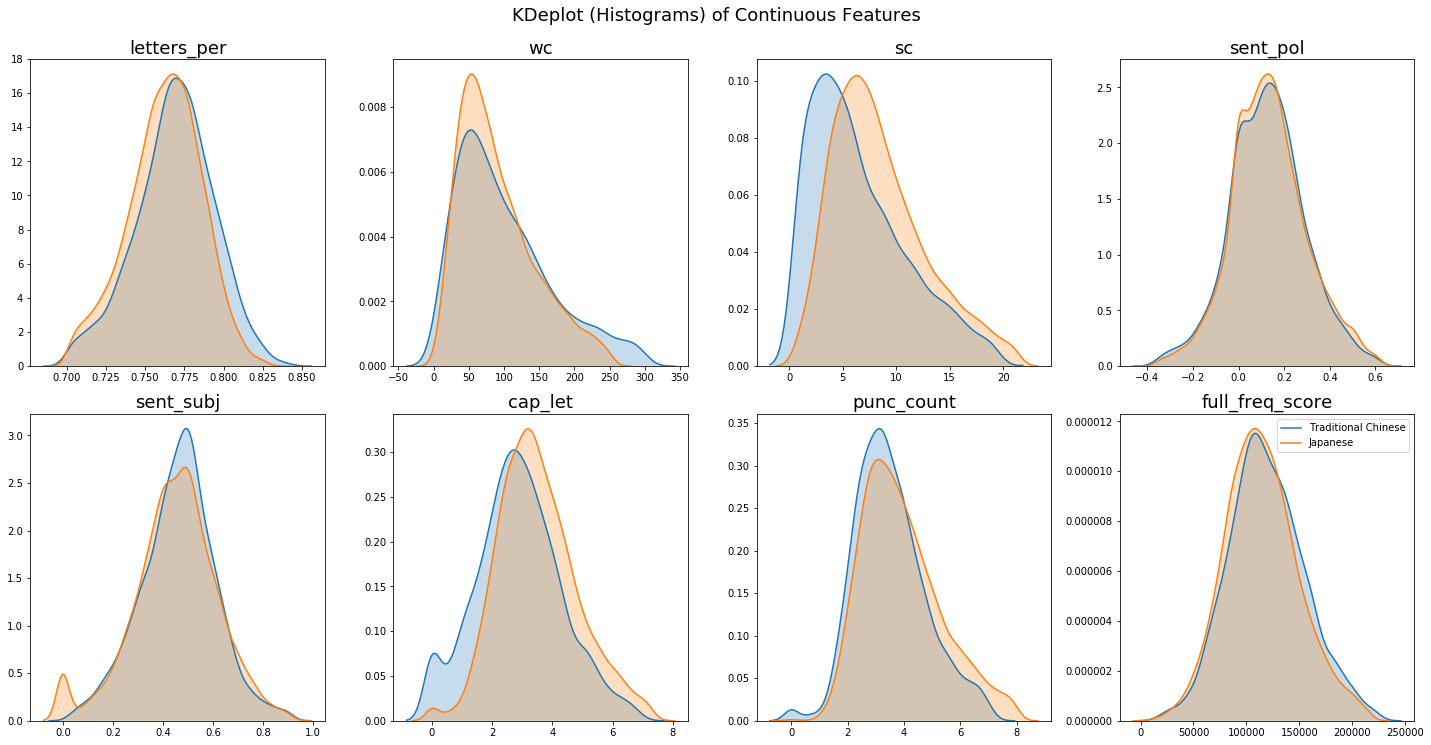

In [63]:
i = 1
fig=plt.figure(figsize=(20,10))
for feat in analysis_features:
    if feat != 'language':
        plt.subplot(2, 4, i)
        i = i + 1
        langfeats = [MEDIAN_reject_outliers(analysis[feat][analysis.language == l]) for l in lang]
        for g in langfeats:
            sns.kdeplot(g,legend=None,kernel='gau',shade=True,)
            plt.title(feat, fontsize=18)

fig.suptitle('KDeplot (Histograms) of Continuous Features', fontsize=18, y=1.03)
plt.tight_layout()
plt.legend(lang)
plt.show()

In [69]:
from scipy.stats import ttest_ind

for c in analysis_features:
    g = [(blog[c][blog.language == l]) for l in lang]
    stat,p = ttest_ind(g[0],g[1])

    if (p < .05) & (p > 0):
        print('{}:\x1b[92m{}\x1b[0m'.format(c,p))
    elif p > .05:
        print('{}:\x1b[31m{}\x1b[0m'.format(c,p))
    else:
        print('{}:\x1b[33m{}\x1b[0m'.format(c,p))

letters_per:3.851288704175285e-25
wc:0.0
sc:0.0
sent_pol:0.0
sent_subj:3.2764552529309356e-38
cap_let:0.0
punc_count:0.0
full_freq_score:1.401298464324817e-45


__Correlations (of top features by decision tree importance)__

In [90]:
%store -r bnb_sorted

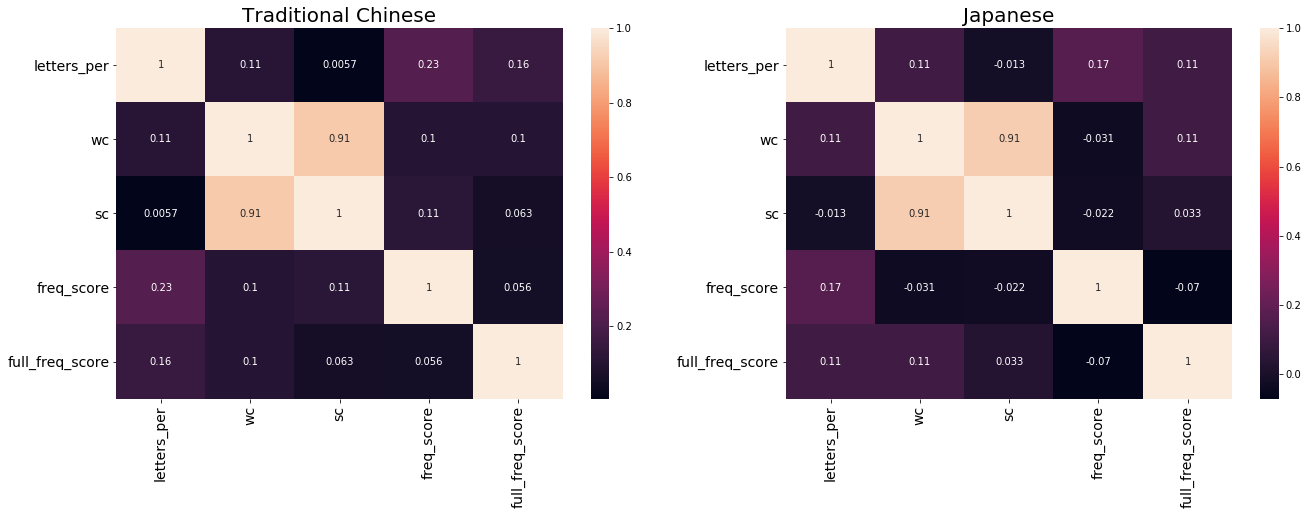

In [98]:
# corr = analysis.corr(); print(corr)
i = 1
fig=plt.figure(figsize=(22,15))

for ind,g in enumerate([(features[bnb_sorted[0:5]][features.language == l]) for l in lang]):
    plt.subplot(2, 2, i)
    i = i + 1
    
    corr = g.corr()
    sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            annot=True)
    plt.title(lang[ind],fontsize = 20)
    plt.xticks(rotation='vertical',fontsize = 14)
    plt.yticks(rotation='horizontal',fontsize = 14)
    
plt.show()

<a id="sec3"></a>

###  <span style="color:darkblue">C. Statistical Significance <a href='#top'>(top)</a>

In [17]:
from scipy.stats import median_test
def mw_test(a,b):
    stat,p = mannwhitneyu(a,b, use_continuity=True, alternative=None)
    return stat,p

def moods_median_test(a,b,c,d):
    stat, p, med, tbl = median_test(a,b,c,d)
    return stat,p

def f1way_test(a,b,c,d):
    f,b = f_oneway(a,b,c,d)
    return f,b

import warnings
warnings.filterwarnings('ignore')

__Mann Whitney U test (2 Non-Normally Distributed Independent Samples)__

__B. Mood’s Median test (2+ Non-Normally Distributed Independent Samples)__

__Null Hypothesis:__ Assumes samples are from same 1st language population.

__B. One-Way AnovaTest (2+ Normally Distributed Independent Samples)__

__Null Hypothesis:__ Assumes samples are from same 1st language population.